# CarMax Analytics Showcase: Winter 2023
## Rory Stevens


In [487]:
# Imports
import re
import pkg_resources
import time
import math
import pandas as pd
from scipy import stats
import missingno as msno
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy import mean, std
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import set_config
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
print(f"matplotlib=={pkg_resources.get_distribution('matplotlib').version}")
print(f"scikit-learn=={pkg_resources.get_distribution('scikit-learn').version}")
# print(f"XGBoost=={pkg_resources.get_distribution('xgboost').version}")

re==2.2.1
pandas==1.2.4
missingno==0.4.2
numpy==1.20.1
seaborn==0.12.1
matplotlib==3.3.4
scikit-learn==1.1.3


### Data Loading and Preliminary Processing

In [405]:
raw_df = pd.read_csv("./Data/ShowcaseDataWinter2023.csv")
raw_memory = raw_df.memory_usage(deep=True).sum()


print(f'Shape: {raw_df.shape}\nMemory Usage: {raw_memory} bytes ... {raw_memory/1000000:.2f} Mb')
raw_df.head()

Shape: (200000, 30)
Memory Usage: 224052594 bytes ... 224.05 Mb


,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,model,trim_descrip,body,color,...,trim_descrip_appraisal,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market
0,$20k to $25k,$0k to $5k,1.0,2014.0,15k to 20k miles,HDT,HDT_12,Premium,E,Red,...,NaN,D,Silver,4.0L,6,17.0,21,236,21.0,13
1,$15k to $20k,$0k to $5k,0.0,2006.0,100k+ miles,KQZ,KQZ_23,Premium,E,Silver,...,Not Premium,D,Gold,4.2L,6,16.0,21,205,25.0,11
2,$30k to $35k,$35k to $40k,1.0,2014.0,5k to 10k miles,CZV,CZV_10,Premium,E,Black,...,NaN,E,Red,2.0L,4,41.0,38,181,10.0,13
3,$35k to $40k,$5k to $10k,1.0,2014.0,15k to 20k miles,IZA,IZA_19,Premium,F,Silver,...,Premium,F,Blue,3.0L,6,17.0,25,230,16.0,13
4,$30k to $35k,$15k to $20k,1.0,2011.0,35k to 40k miles,HDT,HDT_8,Premium,F,Blue,...,Not Premium,E,Black,2.4L,4,20.0,29,182,18.0,16


Taking a look at the 30 features, it is apparent that there are some features that have numerical ranges represented as strings (ex. "20k to 25k miles"). It may be beneficial to convert these to their numeric midpoint for certain analyses.

#### Take a look at dataset info with df.info()

In [406]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    200000 non-null  object 
 1   appraisal_offer          200000 non-null  object 
 2   online_appraisal_flag    196166 non-null  float64
 3   model_year               200000 non-null  float64
 4   mileage                  200000 non-null  object 
 5   make                     200000 non-null  object 
 6   model                    200000 non-null  object 
 7   trim_descrip             176159 non-null  object 
 8   body                     189741 non-null  object 
 9   color                    199967 non-null  object 
 10  engine                   200000 non-null  object 
 11  cylinders                200000 non-null  int64  
 12  mpg_city                 199410 non-null  float64
 13  mpg_highway              199410 non-null  float64
 14  hors

We can see that the majority of features are entirely non-null, and there are a great number of features that are objects.

#### Converting range features

The range representation of `price`, `appraisal_offer`, `mileage`, and `mileage_appraisal` is good for human readability, but for analyzing the data, it would aid in visualization to represent them as numerical values. So, if we take the midpoint of these ranges, we can preserve the relationship while changing the features to numeric values. For other analyses, we can convert them back to their discrete range form.

We don't know where the actual dollar amount or mileage number lies in these ranges, so, in we are not losing data in this process.

In [407]:
def convert_range(range_ : str) -> np.float64:
    '''
    Converts rages (ex. price and mileage) to their midpoint as a float
    :param range_:
    :return:
    '''
    return np.average(list(map(int, re.findall(r'\d+', range_))))

In [408]:
print(raw_df.price.unique())
print('\n', raw_df.appraisal_offer.unique())
print('\n', raw_df.mileage.unique())
print('\n', raw_df.mileage_appraisal.unique())

['$20k to $25k' '$15k to $20k' '$30k to $35k' '$35k to $40k'
 '$45k to $50k' '$25k to $30k' '$40k to $45k' '$0 to $15k' '$55k to $60k'
 '$60k to $65k' '$65k to $70k' '$70k+' '$50k to $55k']

 ['$0k to $5k' '$35k to $40k' '$5k to $10k' '$15k to $20k' '$40k+'
 '$20k to $25k' '$10k to $15k' '$25k to $30k' '$30k to $35k']

 ['15k to 20k miles' '100k+ miles' '5k to 10k miles' '35k to 40k miles'
 '20k to 25k miles' '30k to 35k miles' '45k to 50k miles'
 '70k to 75k miles' '25k to 30k miles' '0 to 5k miles' '10k to 15k miles'
 '80k to 85k miles' '65k to 70k miles' '75k to 80k miles'
 '55k to 60k miles' '50k to 55k miles' '85k to 90k miles'
 '40k to 45k miles' '90k to 95k miles' '95k to 100k miles'
 '60k to 65k miles']

 ['200k+ miles' '0 to 10k miles' '10k to 20k miles' '100k to 110k miles'
 '20k to 30k miles' '160k to 170k miles' '30k to 40k miles'
 '80k to 90k miles' '60k to 70k miles' '110k to 120k miles'
 '70k to 80k miles' '90k to 100k miles' '190k to 200k miles'
 '150k to 160k miles' '1

Using `df.unique()`, we see that the maximum values for `price`, `appraisal_offer`, `mileage`, and `mileage_appraisal` are &#36;70k+, &#36;40k+, 100k+ miles, and 200k+ miles, respectively.

In [409]:
# String features that represent numerical ranges
range_feats = ['price', 'appraisal_offer', 'mileage', 'mileage_appraisal']

# Convert each range-based feature value to the midpoint of the range. These are then kept as float as there exists an ordinal relationship. We could also use an OrdinalEncoder/LabelEncoder later as well.
for feature in range_feats:
    raw_df[feature] = raw_df[feature].apply(convert_range)
# Confirm changes with .dtypes and .head()

In [410]:
# Check conversion with df.head()
raw_df.head()

,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,model,trim_descrip,body,color,...,trim_descrip_appraisal,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market
0,22.5,2.5,1.0,2014.0,17.5,HDT,HDT_12,Premium,E,Red,...,NaN,D,Silver,4.0L,6,17.0,21,236,21.0,13
1,17.5,2.5,0.0,2006.0,100.0,KQZ,KQZ_23,Premium,E,Silver,...,Not Premium,D,Gold,4.2L,6,16.0,21,205,25.0,11
2,32.5,37.5,1.0,2014.0,7.5,CZV,CZV_10,Premium,E,Black,...,NaN,E,Red,2.0L,4,41.0,38,181,10.0,13
3,37.5,7.5,1.0,2014.0,17.5,IZA,IZA_19,Premium,F,Silver,...,Premium,F,Blue,3.0L,6,17.0,25,230,16.0,13
4,32.5,17.5,1.0,2011.0,37.5,HDT,HDT_8,Premium,F,Blue,...,Not Premium,E,Black,2.4L,4,20.0,29,182,18.0,16


#### Changing engine sizes (contains 'L') to numerical values

We can safely remove the 'L' at the end of the values in the two engine features, because we know that all values in this column share the same unit, liters.

Important Note:
The units of engine size are almost always expressed as liters, but it is important to remember, as a general case, that it cannot always be assumed that units are consistent. You could lose information by removing unit designation.

In [411]:
def clean_engine(df : pd.DataFrame) -> pd.DataFrame:
    """
    Takes the customer DataFrame as a parameter and returns the DataFrame with engine columns converted to floats
    :param df:
    :return:
    """
    # Only two features need converting
    slice_feats = ['engine', 'engine_appraisal']

    for feature in slice_feats:
        # Get rid of last character
        df[feature] = df[feature].str.slice(start = 0, stop = -1)
        # Convert column to numeric and downcast
        df[feature] = pd.to_numeric(df[feature], downcast = "float")
    return df


raw_df = clean_engine(raw_df)
print(f'New dtype for engine and engine_appraisal: {raw_df.engine.dtype}')

New dtype for engine and engine_appraisal: float32


### Memory Optimization
Memory optimization in a Jupyter notebook such as this would only be for the purposes of preventing memory errors and slow performance on constrained hardware. However, it is worth noting the data types and ways to optimize memory usage to get a better understanding of the data, their possible values, and optimal ways to store such data.

For nullable integers, we can use the nullable-integer extension dtypes in pandas
- Int8
- Int16
- Int32
- Int64

In [412]:
# Begin building the schema
# We already know the range features we converted are np.float64 given that we used np.average
# They also have hard limits, so we can safely use a smaller float dtype
schema={
    'price' : 'float16',
    'appraisal_offer': 'float16',
    'mileage' : 'float16',
    'mileage_appraisal' : 'float16'
}

#### Fuel Capacity

In [413]:
# Looking at fuel_capacity and fuel_capacity_appraisal..
print(raw_df['fuel_capacity'].unique())
print(raw_df['fuel_capacity_appraisal'].unique())
# All unique values can be represented by a nullable Int16 without losing data
schema['fuel_capacity'] = 'Int16'

[16. 18. 15. 19. 14. 31. 12. 13. 17. 24. 22. 38. 26. 28.  7. 21. 11. 23.
 20. 36.  8. 10. 35.  9. 27. 32. 48. 34. 25.  2. 29. nan 33.  1. 41. 30.
 37.]
[21. 25. 10. 16. 18. 19. 13. 22. 20. 14. 17. 26. 15. 23. 11. 12. 28. 24.
 31. nan 36.  9. 34. 35. 30.  8. 38. 27. 32. 33.  7. 42. 29. 48. 37. 39.]


#### Model Year
model_year and model_year_appraisal, with type float64, can be better stored as int32 since years are inherently unsigned 'small' integers (we will keep it as signed in case some special encoding is needed later). There are also no NaN's present, so a nullable type is not needed


In [414]:
schema['model_year'] = 'int32'
schema['model_year_appraisal'] = 'int32'

#### Online Appraisal Flag

In [416]:
# Looking at the online appraisal feature, it appears that it is a binary feature with missing values.
print(raw_df.online_appraisal_flag.unique())
schema['online_appraisal_flag'] = 'category'

[ 1.  0. nan]


#### Make
There is a set of distinct makes, so we can make this a categorical variable

In [417]:
print(raw_df.make.unique())
schema['make'] = 'category'

['HDT' 'KQZ' 'CZV' 'IZA' 'OFW' 'LTX' 'FVQ' 'ARU' 'HXQ' 'BDP' 'CFK' 'CIP'
 'AIH' 'JHO' 'BGZ' 'FJE' 'MBN' 'JJQ' 'NHY' 'NKR' 'GUK' 'LYP' 'JDZ' 'BZQ'
 'HAE' 'BXO' 'FPH' 'HYS' 'JGV' 'HAN' 'NAJ' 'NYP' 'IZN' 'DVE' 'KDM' 'FJR'
 'BIS']


#### Model
The model distinction is far more specific than make (intuitively). Additionally, if we extracted the model number from this feature and simply made that a column of itself for better readability/differentiation, it would misrepresent the data because a model number 'n' on one make is not the same as a model number 'n' on another.

In [418]:
print(f'Number of models : {len(raw_df.model.unique())}')

Number of models : 575


#### Trim Description, Body, Color
These features appear to be categorical in nature with some NaN values, so the best dtype would be category.

In [419]:
print(f'trim_descrip: {raw_df.trim_descrip.unique()}')
print(f'\nbody: {raw_df.body.unique()}')
print(f'\ncolor: {raw_df.color.unique()}')
schema['trim_descrip'] = 'category'
schema['trim_descrip_appraisal'] = 'category'
schema['body'] = 'category'
schema['body_appraisal'] = 'category'
schema['color'] = 'category'
schema['color_appraisal'] = 'category'

trim_descrip: ['Premium' 'Not Premium' nan]

body: ['E' 'F' 'B' nan 'D' 'G' 'A']

color: ['Red' 'Silver' 'Black' 'Blue' 'White' 'Gray' 'Burgundy' 'Gold' 'Brown'
 'Green' 'Pearl' 'Purple' 'Tan' 'Orange' nan 'Yellow' 'Unknown']


#### Engine
We already found that the two engine features were best changed to floats because the unit designation of 'L' was constant and they are (somewhat) continuous  values.

Additionally, since engine sizes cannot be extremely large values, we already downcast the output from our conversion to numeric.

In [420]:
print(f'Data type of engine and engine_appraisal after conversion: {raw_df.engine.dtype}')

Data type of engine and engine_appraisal after conversion: float32


#### Cylinders
The cylinders feature has an ordinal relationship and a typically defined range, so we can change this to int16 since it also has no null values.

In [421]:
print(f'Unique cylinder values: {raw_df.cylinders.unique()}')
print(f'Unique appraised cylinder values: {raw_df.cylinders_appraisal.unique()}')
schema['cylinders'] = 'int16'
schema['cylinders_appraisal'] = 'int16'

Unique cylinder values: [ 4  6  8  3  0  5  2 10 12 16]
Unique appraised cylinder values: [ 6  4  8  5  3 10]


#### MPG, Fuel Capacity, and  Horsepower
mpg_city, mpg_highway, fuel_capacity, and horsepower for the purchased and appraised vehicle have dtypes of float64, float64, float64, and int64. Because mpg_city, mpg_highway have null values, we can keep these as float64 (a nullable type). For horsepower, an integer column which has no null values, we can save memory and downcast this column.

In [422]:
print(f'Horsepower max: {raw_df.horsepower.max()}\nHorsepower Min: {raw_df.horsepower.min()}')
schema['horsepower'] = 'int32'
schema['horsepower_appraisal'] = 'int32'

Horsepower max: 760
Horsepower Min: 11


#### Market
Market is listed as a string value representing the market in which the transaction occurred. Since this number has no ordinal relationship, it should be made a categorical column.

In [423]:
print(f'Market Max: {raw_df.market.max()}\nMarket Min: {raw_df.market.min()}')
print(sorted(raw_df.market.unique()))
schema['market'] = 'category'

Market Max: 16
Market Min: 1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


#### Data type inspection and Memory Optimization: Conclusions

Using the schema created during our inspection of the feature's data types, we can get a ~75% reduction in memory usage! Again, this is not a requirement for performing data science tasks, but it is certainly a good exercise on learning where performance can be gained when working with large amounts of data. In a data storage layer, this data is certainly already optimized to be as small as possible to save on costs.

In [424]:
# Astype conversion
trimmed_raw_df = raw_df.astype(schema)
trimmed_raw_memory = trimmed_raw_df.memory_usage(deep=True).sum()

print(f'Raw Dataframe Memory Usage: {raw_memory} bytes ... {raw_memory/1000000:.2f} Mb')
print(f'Optimized Dataframe Memory Usage: {trimmed_raw_memory} bytes ... {trimmed_raw_memory/1000000:.2f} Mb')
print(f'% Memory Reduction from raw dataframe to optimized dataframe {((raw_memory - trimmed_raw_memory) / raw_memory * 100) : .2f} %\n')
trimmed_raw_df.info()

Raw Dataframe Memory Usage: 224052594 bytes ... 224.05 Mb
Optimized Dataframe Memory Usage: 53965739 bytes ... 53.97 Mb
% Memory Reduction from raw dataframe to optimized dataframe  75.91 %

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  float16 
 1   appraisal_offer          200000 non-null  float16 
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  float16 
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine               

### Analyzing Nulls

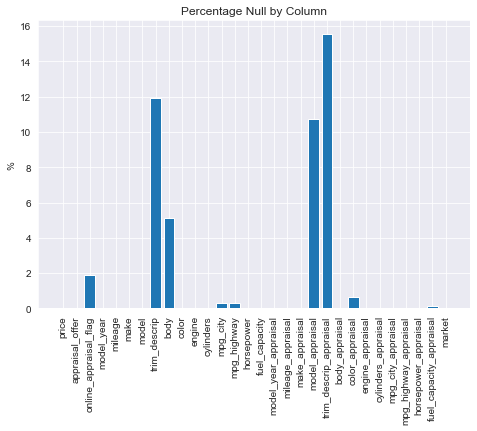

In [425]:
# Make a list of the percentage of null values for each column
null_portions = [(trimmed_raw_df[column].isnull().sum()/trimmed_raw_df.shape[0]*100) for column in trimmed_raw_df.columns ]
null_dict = dict(zip(list(trimmed_raw_df.columns), null_portions))

# Plot the null percentage for each column
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(trimmed_raw_df.columns), null_portions)
plt.xticks(rotation = 90)
plt.title("Percentage Null by Column")
plt.ylabel("%")
plt.show()

Looking at the % of null values in each column, it appears that `online_appraisal_flag`, `trim_descrip`, `body`, `model_appraisal`, and `trim_descrip_appraisal` have significant portions of missing values, with `mpg_city`, `mpg_highway`, `color_appraisal`, and `fuel_capacity_appraisal` having a small number of missing values as well.

The next question we can formulate from this information is, "How concentrated are these missing values?".

To check this, we can look at the portion of rows that have at least one null.


In [426]:
print(f'Rows that have at least one null:\nCount - {trimmed_raw_df.isna().any(axis=1).sum()}\nPercentage - {trimmed_raw_df.isna().any(axis=1).sum()/trimmed_raw_df.shape[0]*100:.2f}%')

Rows that have at least one null:
Count - 71317
Percentage - 35.66%


If we look at the percentage of rows that have missing (null) values, we can see that it represents over a third of our dataset.
This means that our null values are not entirely concentrated (ex. rows with multiple nulls).


Now we need to analyze our null rows against non-null, to check if there are any striking differences in distribution.

In [427]:
numerical_columns = trimmed_raw_df.select_dtypes(include = 'number').columns
categorical_columns = trimmed_raw_df.select_dtypes(exclude = 'number').columns

In [428]:
def compare_hists(df : pd.DataFrame, features, rows : int , cols : int):
    """
    Compares the histograms of null vs non-null for each of the input features
    :param df: pandas DataFrame that contains comparison data
    :param features: features to compare
    :param rows: rows passed to axes object for subplot grid
    :param cols: columns passed to axes object for subplot grid
    :return:
    """
    # Null and partial null subset creation
    nn_df = df.dropna(axis = 0, how ="any")
    n_df = df[df.isna().any(axis=1)]

    # Plot creation for each feature
    fig = plt.figure(figsize=(25,100),)
    for i, feat in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        nn_df[feat].hist(bins=75,ax=ax, alpha=0.5, color = 'green', label = 'Non-null', density = True)
        n_df[feat].hist(bins = 75,ax = ax, alpha = 0.5, color = 'red', label ='Null', density = True)
        plt.legend(loc='upper right')
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        ax.set_title(f"Null vs Non-null: {feat}", fontdict={'fontsize': 18})


    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.5)  # Improves appearance a bit.
    plt.show()

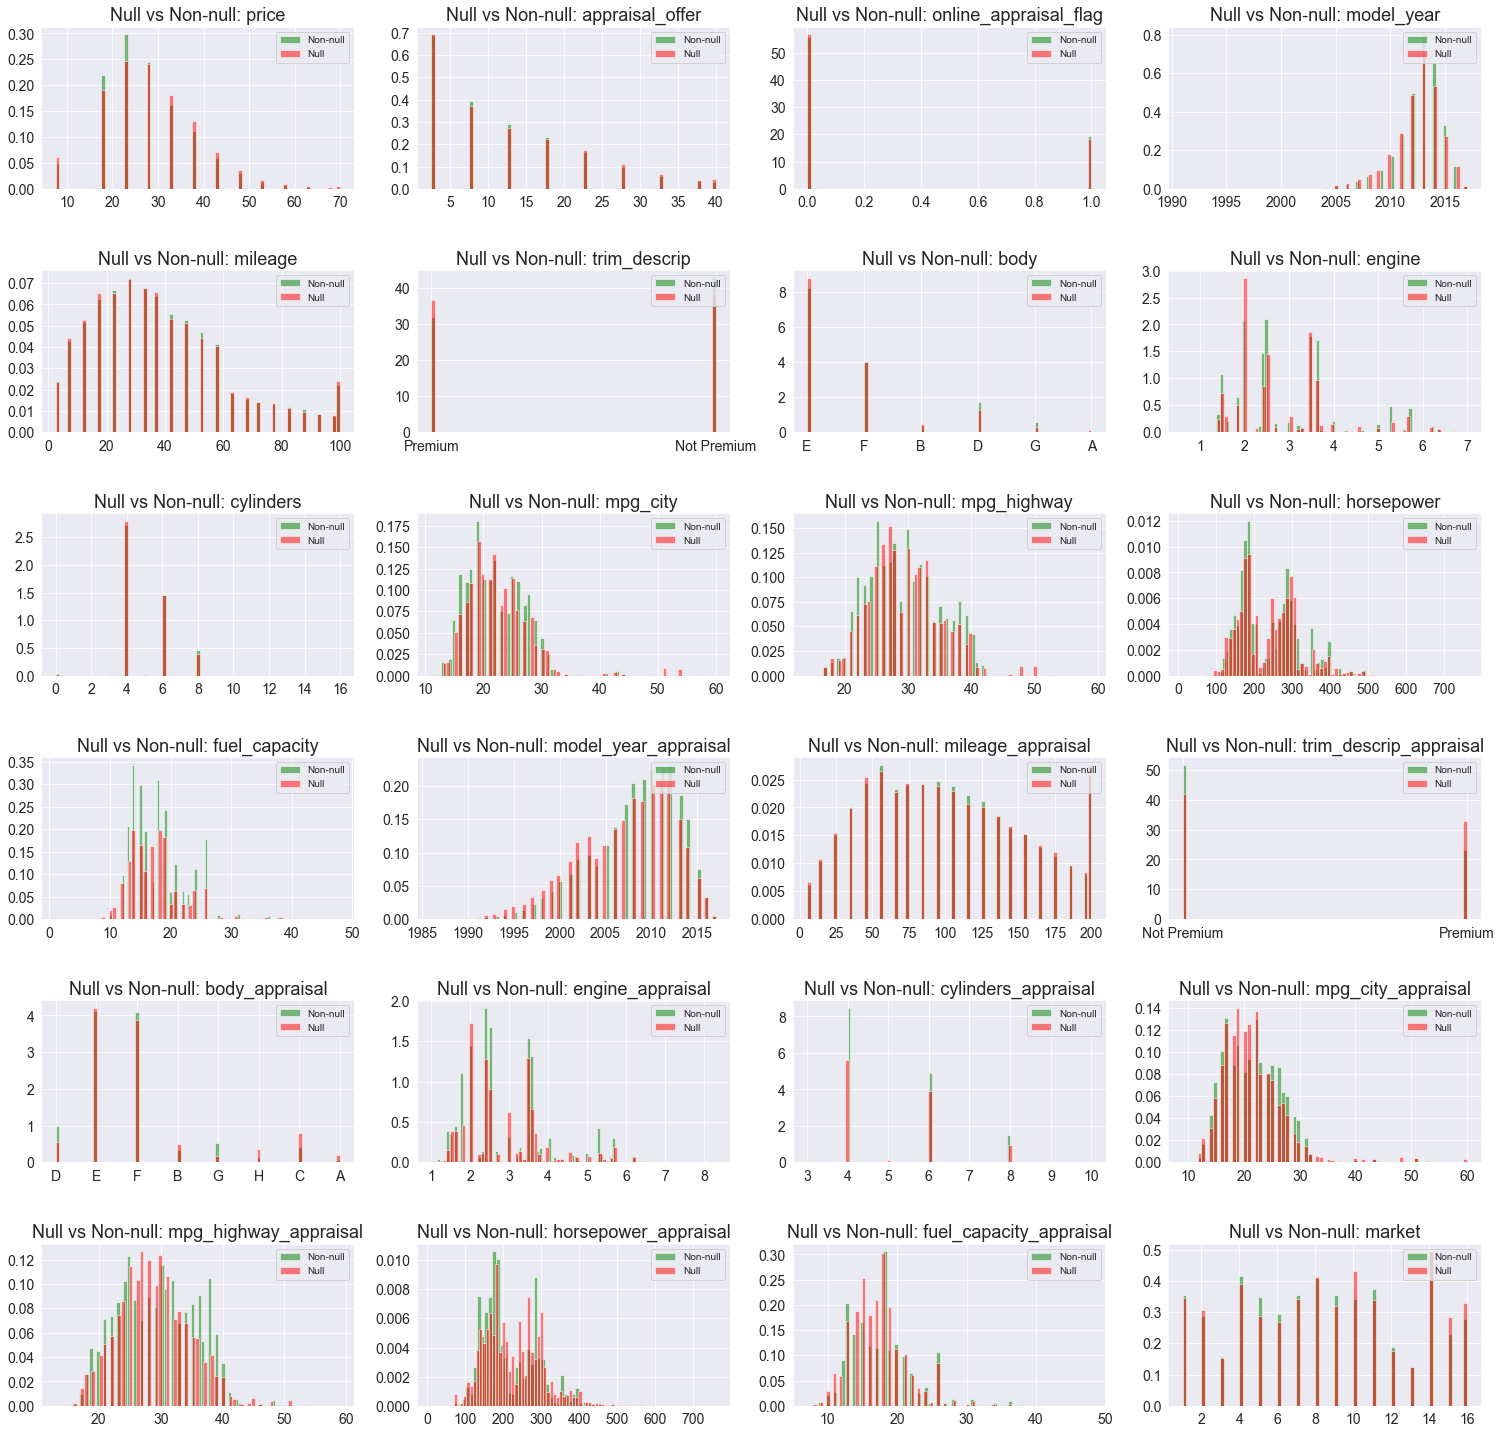

In [429]:
feats = list(trimmed_raw_df.drop(['make', 'make_appraisal', 'model', 'model_appraisal', 'color', 'color_appraisal'], axis =1).columns)
compare_hists(trimmed_raw_df, feats, len(feats), 4)

A quick way to analyze the differences between different datasets of the same schema is to overlay the distributions of each feature. In this case we have left out some non-numeric columns that have a large number of unique values, which would make it difficult to analyze.

Currently, we have the 'density' kwarg selected as true, this ensures a histogram whose integral is constrained to equal one. This helps compare these two datasets, as their sizes are extremely different. From this array of histograms we can see that the distributions are mostly the same shape.

In [430]:
def compare_categorical(df: pd.DataFrame, feat : str, **kwargs):
    """
    Takes the non-null, and partial null portions of a dataset and compares them with an superimposed bar plot
    :param df: Pandas DataFrame whose categorical feature is to be compared
    :param feat: feature to compare
    :param kwargs:
    :return: bar plot of the null, partial-null comparison
    """

    # Null and partial null subset creation
    nn_df = df.dropna(axis = 0, how ="any")
    n_df = df[df.isna().any(axis=1)]

    fig, ax = plt.subplots()

    # Generate plots for % of each value-count
    n_df[feat].value_counts().apply(lambda x : x/n_df.shape[0]*100).plot(ax=ax, label = 'null', kind='bar', alpha = 0.5, color = 'red')
    nn_df[feat].value_counts().apply(lambda x : x/nn_df.shape[0]*100).plot(ax=ax, label = 'non-null', kind='bar', alpha = 0.5)
    plt.ylabel('% of Instances', fontsize = 14)
    plt.xlabel(feat, fontsize = 14);
    plt.legend(loc = 'upper right')
    ax.set_title(f'Comparison of {feat} Between Null and Non-Null')

    # Take off xticks; used for features that have large number of unique strings because the x-axis would be unreadable
    try:
        if kwargs['xticks'] == 'off':
            plt.xticks([],[])
    except KeyError:
        pass

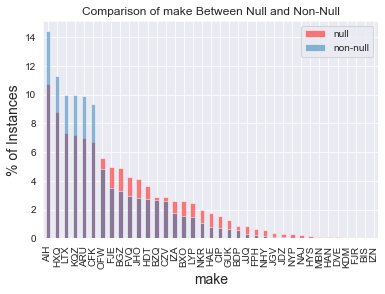

In [431]:
# Looking at the distributions of make for non-null vs null
compare_categorical(trimmed_raw_df, 'make')

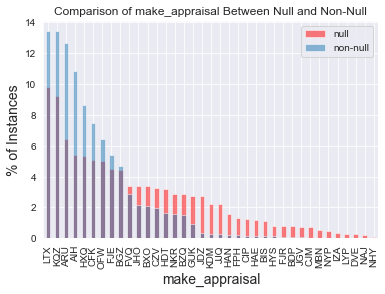

In [432]:
# Looking at the distributions of make_appraisal for non-null vs null
compare_categorical(trimmed_raw_df, 'make_appraisal')

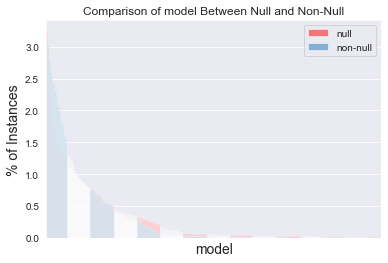

In [433]:
# Looking at the distributions of model for non-null vs null
compare_categorical(trimmed_raw_df, 'model', xticks = 'off')

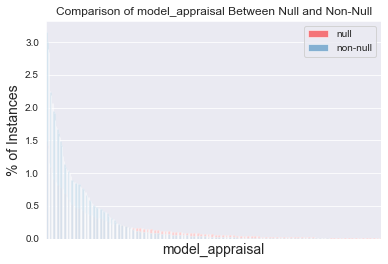

In [434]:
compare_categorical(trimmed_raw_df, 'model_appraisal', xticks = 'off')

We can see that the make and model features give different shapes for null and non-null row distributions.

**What inferences/assumptions can we make from this?** The further right in the bar graph, the fewer occurrences of this vehicle make/model appear in the dataset, meaning that the rows with nulls are more comprised of 'rarer' vehicle makes/models than rows without nulls. This may make giving a data point for every feature more difficult for the appraiser, as these rarer makes/models may lack sufficient documentation about their details.

Overall, there is no cause for alarm when comparing the missing vs non-missing data rows, so we do not need to complete any extensive processing/comparison for these instances.

#### Nullity Correlation

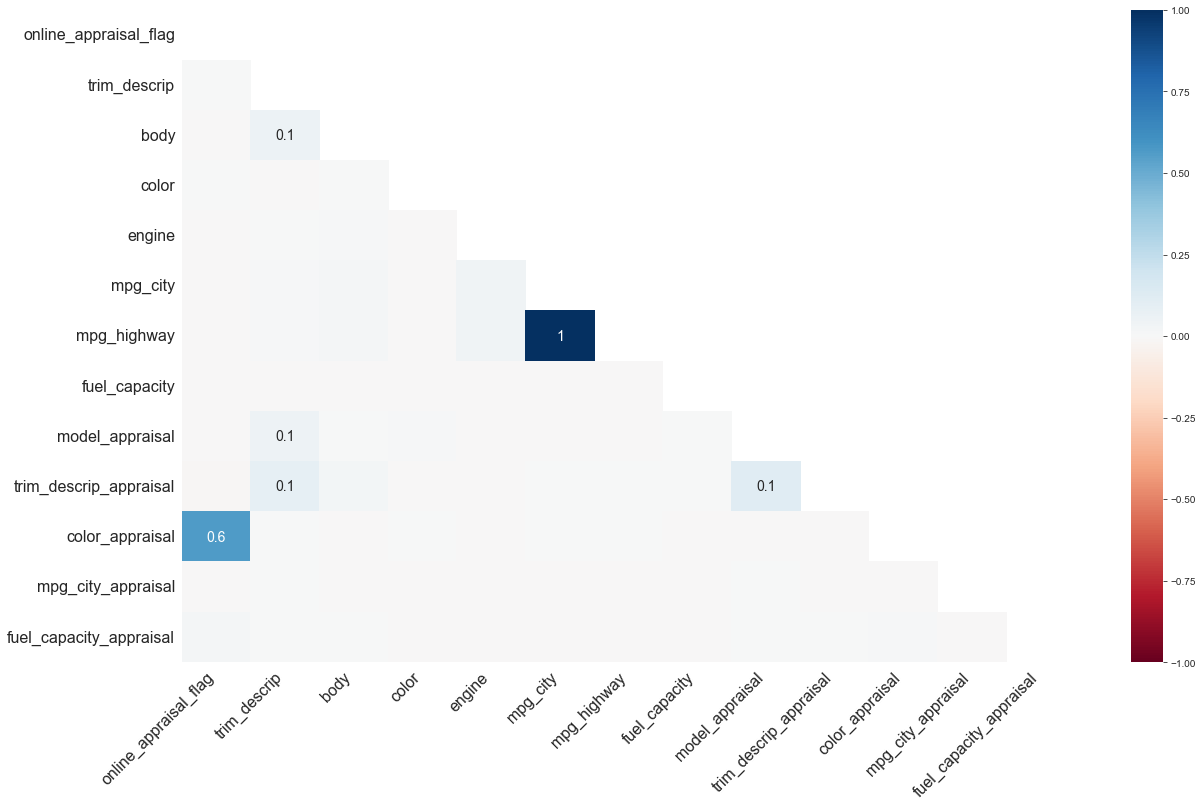

In [435]:
msno.heatmap(trimmed_raw_df);

When color_appraisal is not null, there is a high likelihood that the online_appraisal_flag will also not be null.
Additionally, if one of the mpg feature values is non-null, then it is almost certain that the other is non-null as well (same for when one is null).

In [436]:
# Confirming the results from this nullity correlation heatmap
trimmed_raw_df[trimmed_raw_df['color_appraisal'].isna()]['online_appraisal_flag'].value_counts(dropna = False)


NaN    1279
0.0      26
1.0      13
Name: online_appraisal_flag, dtype: int64

The relationship between the color of the appraised car and the online appraisal flag, in regard to nulls, does not have any clear logical connection.

One potential explanation could be a policy/procedural change. Since there are no dates provided with the dataset instances, we cannot see any date-wise shift in data. However, it may be plausible that some kind of policy change took place regarding the entry of color data  and whether the appraisal was online.

### Correlations

In [437]:
trimmed_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  float16 
 1   appraisal_offer          200000 non-null  float16 
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  float16 
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine                   199999 non-null  float32 
 11  cylinders                200000 non-null  int16   
 12  mpg_city                 199410 non-null  float64 
 13  mpg_highway              199410 non-null  fl

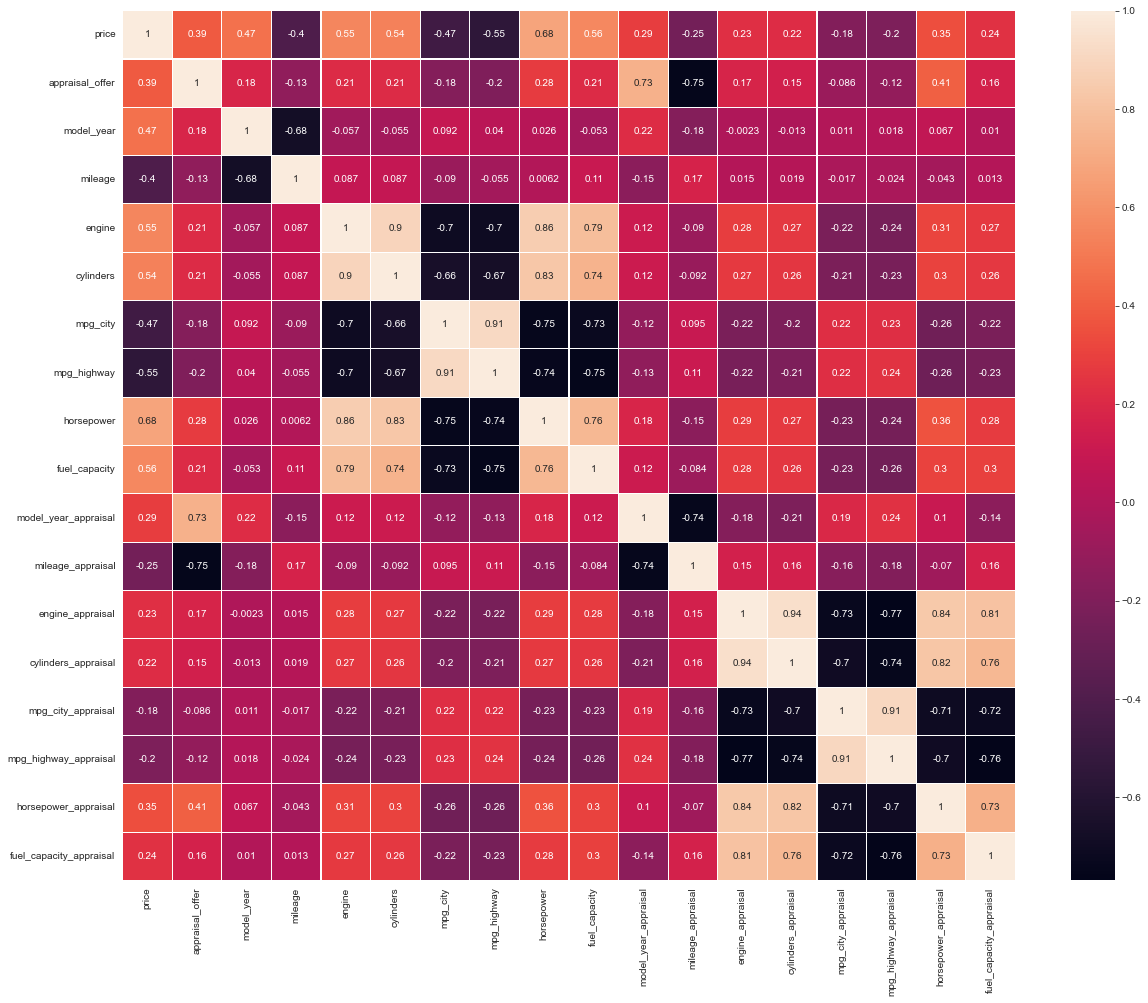

In [438]:
fig,ax = plt.subplots(figsize=(20,16))
heat_fig = sns.heatmap(trimmed_raw_df.select_dtypes(include = 'number').corr(), xticklabels = trimmed_raw_df.select_dtypes(include = 'number').columns, yticklabels = trimmed_raw_df.select_dtypes(include = 'number').columns,linewidths=0.1, annot = True)

Right away we can see some strong correlations, most of which are intuitive.
Note: A significant reason for making the binned ranges 'continuous' is to help with visualizations such as this correlation heatmap.

**Intuitive Correlations**
* Horsepower, engine, cylinders, and fuel capacity are all positively correlated. This makes sense because those traits intrinsically go together.
* Price positively correlates with the aforementioned traits as well as model year. This is reasonable to assume because newer cars and larger, sportier cars tend to be more expensive.
* Appraised car mileage and appraisal offer are negatively correlated.

For our purposes, we care more about the correlations between the appraised car and the purchased car.

**Appraised and Purchased Vehicle Correlations**
* Price of purchased car and the horsepower of the appraised vehicle have a slight positive correlation of 0.35.
* The appraisal offer and price of the purchased car have a slight positive correlation of 0.39.
* Horsepower, cylinders, fuel capacity, and engine trend positively with between that of the appraised and purchased vehicle.

#### Horsepower Designation Retention

Because we do not have truth labels for vehicle type (sport, truck, economy, etc.) we can try to gather some conclusions from looking at an arbitrary 3-way (approximate) split on horsepower. We can divide the dataset into High, Low, and Average bins regarding horsepower using th cutoffs of:
```python
       <-1/2 SD        -1/2 to +1/2 SD        >+1/2 SD
|                   |                   |                   |
```
Where the 'low' horsepower vehicles are less than the mean minus one-half the standard deviation, and the 'high' horsepower vehicles are greate than the mean plus one-half the standard deviation. The 'average' vehicles are everything in-between.

Recommendation for the vehicle trade-in data collection procedure:
Generate some label for appraised/purchased cars regarding type (ex.sport, sedan, truck) to offer better differentiation of vehicles. This and similar data would aid in generic clustering/modelling.

In [439]:
# Standard deviation-based values to segment horsepower
plus_sigma = trimmed_raw_df['horsepower'].mean() + trimmed_raw_df['horsepower'].std()/2
minus_sigma = trimmed_raw_df['horsepower'].mean() - trimmed_raw_df['horsepower'].std()/2

# function to bin horsepower
def bin_hp(row):
    if row['horsepower'] >= plus_sigma:
        return 'High'
    elif row['horsepower'] <= minus_sigma:
        return 'Low'
    else:
        return 'Average'

trimmed_raw_df = trimmed_raw_df.assign(horsepower_hl = trimmed_raw_df.apply(bin_hp, axis=1))

# function to bin horsepower_appraisal
def bin_hp_appraisal(row):
    if row['horsepower_appraisal'] >= plus_sigma:
        return 'High'
    elif row['horsepower_appraisal'] <= minus_sigma:
        return 'Low'
    else:
        return 'Average'

plus_sigma = trimmed_raw_df['horsepower_appraisal'].mean() + trimmed_raw_df['horsepower_appraisal'].std()/2
minus_sigma = trimmed_raw_df['horsepower_appraisal'].mean() - trimmed_raw_df['horsepower_appraisal'].std()/2
trimmed_raw_df = trimmed_raw_df.assign(horsepower_appraisal_hl = trimmed_raw_df.apply(bin_hp_appraisal, axis=1))


# Generate specific transition values for plotting purposes
h_to_l = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='High') &
                            (trimmed_raw_df['horsepower_hl']=='Low')])
l_to_h = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Low') &
                            (trimmed_raw_df['horsepower_hl']=='High')])

l_to_l = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Low') &
                            (trimmed_raw_df['horsepower_hl']=='Low')])
h_to_h = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='High') &
                            (trimmed_raw_df['horsepower_hl']=='High')])

h_to_a = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='High') &
                            (trimmed_raw_df['horsepower_hl']=='Average')])
l_to_a = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Low') &
                            (trimmed_raw_df['horsepower_hl']=='Average')])

a_to_l = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Average') &
                            (trimmed_raw_df['horsepower_hl']=='Low')])
a_to_h = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Average') &
                            (trimmed_raw_df['horsepower_hl']=='High')])
a_to_a = len(trimmed_raw_df[(trimmed_raw_df['horsepower_appraisal_hl']=='Average') &
                            (trimmed_raw_df['horsepower_hl']=='Average')])


labels = ('H to L', 'L to H', 'L to L', 'H to H', 'H to A', 'L to A', 'A to A', 'A to L', 'A to H')
values = np.array([h_to_l, l_to_h, l_to_l, h_to_h, h_to_a, l_to_a, a_to_a, a_to_l, a_to_h])

values = values/trimmed_raw_df.shape[0]*100


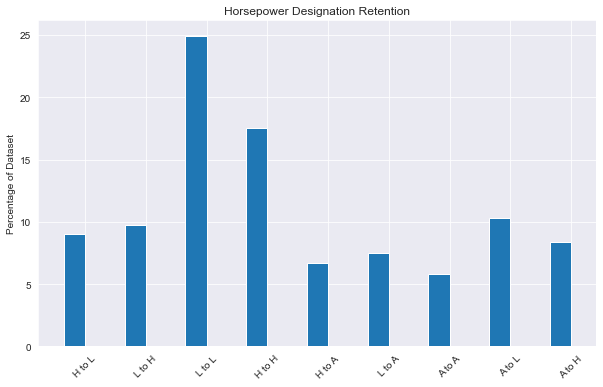

In [440]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))
width = 0.35

plt.bar(x-width/2, values, width)

plt.ylabel('Percentage of Dataset')
plt.title('Horsepower Designation Retention')
plt.xticks(x, labels, rotation=45)

plt.show()

In [441]:
trimmed_raw_df = trimmed_raw_df.drop(['horsepower_hl','horsepower_appraisal_hl'], axis=1)

This columnar analysis shows the shifts in customer's horsepower levels. A good piece of information here is that if someone appraises a 'low' horsepower vehicle, it is highly likely that they will also purchase a low horsepower vehicle. To a similar degree are the 'high' horsepower vehicles.

This could be helpful in that CarMax can recommend lower horsepower (and higher efficiency) vehicles to a customer that brings a low horsepower vehicle in for appraisal.

### Quick Look at Make Loyalty
There may be some interesting insights in whether a customer purchases the same make as their appraised vehicle

Text(0.5, 1.0, 'Percent Customers that Purchased the Same Make of their Appraised Vehicle')

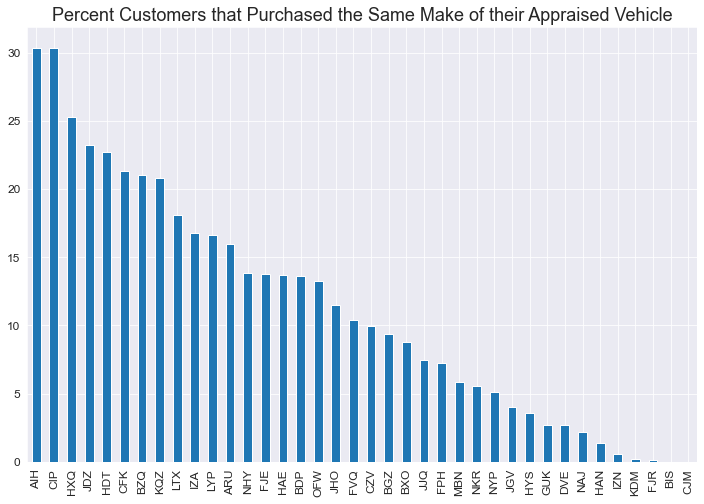

In [442]:
# generate boolean series
trimmed_raw_df['make_loyalty'] = np.where(trimmed_raw_df['make_appraisal']==trimmed_raw_df['make'], True, False)

# make percents from value counts
make_loyalty = trimmed_raw_df.loc[trimmed_raw_df['make_loyalty']==True, 'make_appraisal'].value_counts()/trimmed_raw_df['make_appraisal'].value_counts()*100

# sort the series for better plot visualization
make_loyalty = make_loyalty.sort_values(ascending = False)

ax = make_loyalty.plot.bar(figsize = (12, 8), fontsize = 12)
plt.title(label = 'Percent Customers that Purchased the Same Make of their Appraised Vehicle', fontsize = 18)

In [443]:
# Remove this column, no longer necessary
trimmed_raw_df.drop(['make_loyalty'], axis=1, inplace=True)

Disregarding the right extreme of this graph as some makes that are appraised might not be available for purchase (old brands that changed name, uncommon imported cars, or makes that no longer exist), the left extreme shows that for AIH and CIP, customers will purchase the same make more than 30% of the time. This would be a good piece of information to keep in mind  when a customer comes to CarMax to trade in one of these two makes.

### Cleaning Missing Values

From our analysis thus far, we've looked at the distributions of variables, the number of missing values, and the primary locations of missing values.

From this information, we need to test the numerical features for normality and scope potential cleaning methods.
These methods may include:
* KNN
* Mean, Median, Mode, Constant
* MICE (Multiple Imputation by Chained Equations)
* Dropping

<AxesSubplot:>

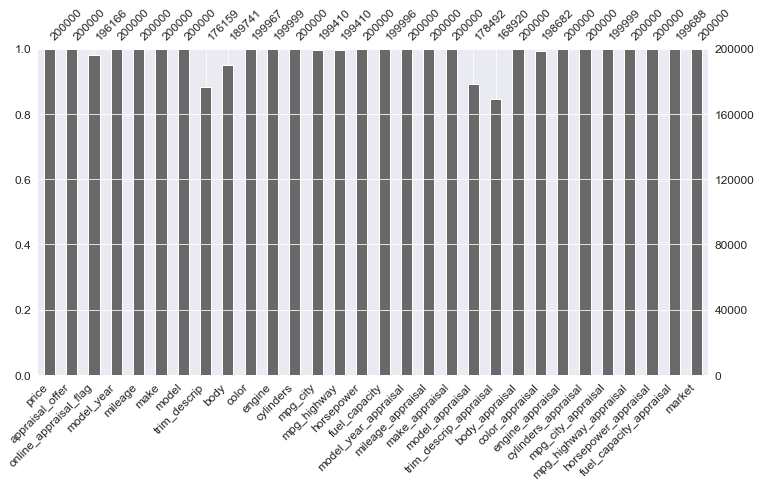

In [444]:
# Recap number and location of missing values:
msno.bar(trimmed_raw_df, figsize=(12, 6), fontsize=12)

We can make different datasets, with different imputation methods, to compare performance.
Additionally, some models can handle null values.

In [220]:
trimmed_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  float16 
 1   appraisal_offer          200000 non-null  float16 
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  float16 
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine                   199999 non-null  float32 
 11  cylinders                200000 non-null  int16   
 12  mpg_city                 199410 non-null  float64 
 13  mpg_highway              199410 non-null  fl

In [446]:
# generate list of numerical and categorical columns
numerical_columns = trimmed_raw_df.select_dtypes(include = 'number').columns
categorical_columns = trimmed_raw_df.select_dtypes(exclude = 'number').columns

shapiro_dict={}
for col in numerical_columns:
    shapiro_dict[col] = stats.shapiro(trimmed_raw_df.dropna()[col].sample(n=100, random_state = 42).values)
# imputations
# most frequent for categorical, mean for numerical
print('Shapiro-Wilk Test p-values for each feature:\n')
for key, val in shapiro_dict.items():
    print(f'{key}:{val.pvalue}')

Shapiro-Wilk Test p-values for each feature:

price:0.0002365182590438053
appraisal_offer:2.6685306409035547e-08
model_year:1.2975300478501595e-07
mileage:1.1878460099978838e-06
engine:1.4011563962412765e-06
cylinders:1.1813923450620933e-10
mpg_city:0.006467463914304972
mpg_highway:0.01729583740234375
horsepower:2.2731943317921832e-05
fuel_capacity:0.00025642861146479845
model_year_appraisal:0.00775153050199151
mileage_appraisal:0.00041542365215718746
engine_appraisal:2.9198815809650114e-07
cylinders_appraisal:8.468020664016696e-13
mpg_city_appraisal:0.0005752029246650636
mpg_highway_appraisal:0.0010983245447278023
horsepower_appraisal:1.7403997389919823e-06
fuel_capacity_appraisal:6.333720648399321e-06


From randomly sampling 100 values from each numerical column. We can see with the Shapiro-Wilk Test for Normality that each of these columns is **not** significantly different from a normal distribution (p value is <0.05). This was also seen in the histogram plots shown previously.

100 randomly sampled data points were used because of the note from the scipy docs: "For N > 5000 the W test statistic is accurate but the p-value may not be."

Now that we know our features are normally distributed, we can proceed without any transformations.

Because the purchased vehicle and all it's traits is essentially our target in any modeling that we may do, we cannot impute those values. So we can begin by employing the most basic imputation strategy for our numerical and categorical data: mean and most-frequent.

#### Dropping All NaN Strategy

In [447]:
# drop model and model_appraisal because they will not be useful in further analyses
df_dropped = trimmed_raw_df.drop(['model', 'model_appraisal'], axis=1).dropna()

num_appraisal_cols = [item for item in list(trimmed_raw_df.select_dtypes(include = 'number').columns) if item.find('appraisal') != -1]

#define column transformer for the scaled version of df_dropped
basic_num_scaler = ColumnTransformer([
    ('num_scaler', StandardScaler(), num_appraisal_cols)],
    remainder = 'passthrough',
    verbose = True,
    verbose_feature_names_out = False
)
df_dropped_scaled = pd.DataFrame(basic_num_scaler.fit_transform(df_dropped), columns = basic_num_scaler.get_feature_names_out())

df_dropped_scaled.head()

[ColumnTransformer] .... (1 of 2) Processing num_scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


,appraisal_offer,model_year_appraisal,mileage_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,price,...,cylinders,mpg_city,mpg_highway,horsepower,fuel_capacity,make_appraisal,trim_descrip_appraisal,body_appraisal,color_appraisal,market
0,-0.942148,-2.579317,-1.792782,1.220882,0.722062,-1.091338,-1.382676,-0.172195,1.645757,17.5,...,6,19.0,27.0,285,18,KQZ,Not Premium,D,Gold,11
1,-0.431211,-0.449385,0.062307,0.11459,0.722062,-0.899779,-0.722234,0.174613,-0.362975,37.5,...,4,25.0,34.0,255,15,IZA,Premium,F,Blue,13
2,0.590663,0.615581,-1.421765,-0.438557,-0.786318,-0.325104,-0.061792,-0.491258,0.08341,32.5,...,4,17.0,23.0,305,15,LTX,Not Premium,E,Black,16
3,-0.431211,0.189594,1.175361,0.667736,0.722062,-0.708221,-0.392013,1.034697,0.306602,17.5,...,4,25.0,35.0,185,18,FJE,Not Premium,F,Black,10
4,2.889879,0.828574,-1.236256,3.064703,2.230443,-1.091338,-0.722234,3.295885,0.08341,37.5,...,8,16.0,25.0,455,19,LTX,Not Premium,B,Black,8


#### Simple Imputing Strategy
Mean and Most Frequent

[ColumnTransformer]  (1 of 3) Processing cat_most_frequent, total=   0.1s
[ColumnTransformer]  (2 of 3) Processing numerical_mean, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


<AxesSubplot:>

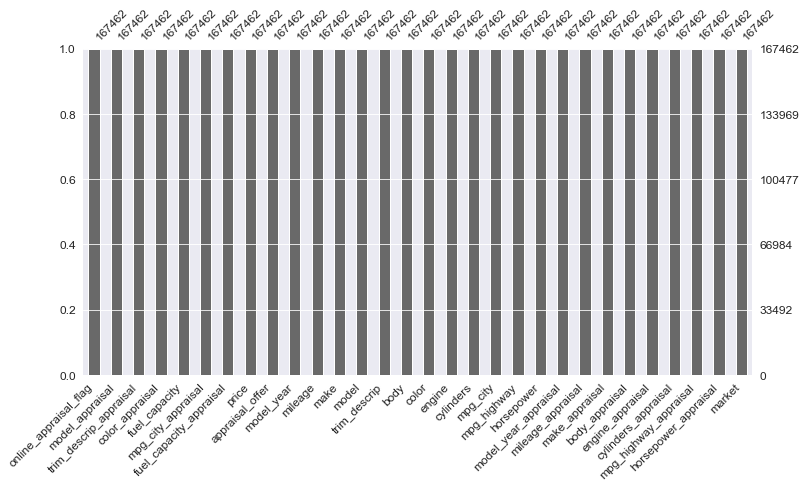

In [449]:
# imputations

# most frequent for categorical, mean for numerical
mean_mf_ct = ColumnTransformer(
    [("cat_most_frequent",
      SimpleImputer(strategy='most_frequent'),
      ['online_appraisal_flag', 'model_appraisal', 'trim_descrip_appraisal',
       'color_appraisal']),
     ("numerical_mean",
      SimpleImputer(strategy ='mean'),
      ['fuel_capacity', 'mpg_city_appraisal', 'fuel_capacity_appraisal' ])],
    remainder='passthrough',
    verbose = True,
    verbose_feature_names_out = False
)

mean_mf_imputed_df = pd.DataFrame(mean_mf_ct.fit_transform(trimmed_raw_df),
                                  columns = mean_mf_ct.get_feature_names_out())
# drop the remaining columns with incomplete targets (technically we don't have to drop them all because we can make models for specific variables)
mean_mf_imputed_dropped_df = mean_mf_imputed_df.dropna()

# make an alias for ease of reading
df_imputed1 = mean_mf_imputed_dropped_df
msno.bar(df_imputed1, figsize=(12, 6), fontsize=12)

In [450]:
print(f'Original Dataset Shape: {trimmed_raw_df.shape}\n'
      f'Imputed Appraised Features with Purchased Vehicle NA\'s Dropped: {df_imputed1.shape}\n'
      f'All NA\'s Dropped: {trimmed_raw_df.dropna().shape}\n')

print(f'Imputed DF % of Original Dataset Size: {df_imputed1.shape[0]/trimmed_raw_df.shape[0]*100:.2f}%\n'
      f'All NA\'s Dropped % of Original Dataset Size: {trimmed_raw_df.dropna().shape[0]/trimmed_raw_df.shape[0]*100:.2f}%')

Original Dataset Shape: (200000, 30)
Imputed Appraised Features with Purchased Vehicle NA's Dropped: (167462, 30)
All NA's Dropped: (128683, 30)

Imputed DF % of Original Dataset Size: 83.73%
All NA's Dropped % of Original Dataset Size: 64.34%


By imputing the appraisal data, we can use 83.73% of the data insead of the 64.34% that would be used if all NAN's were dropped.

#### Simple Imputing Categorical w/ KNN Imputing Numerical Strategy

In [452]:
# Create list of appraisal categorical cols, this list can be used later for dummy encoding
dummy_cols = [item for item in list(trimmed_raw_df.select_dtypes(exclude = 'number').columns) if item.find('appraisal') != -1]

# Add market and remove model
dummy_cols.append('market')
dummy_cols.remove('model_appraisal')


cat_appraisal_cols = ['online_appraisal_flag', 'trim_descrip_appraisal', 'color_appraisal', 'market']

# Pipeline for imputing and scaling numerical columns
knn_pipe_scaled = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
    ('standard_scaler', StandardScaler()),
])

# Pipeling for just KNN imputation
knn_pipe = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
])
# Pipeline to impute categorical columns with most_frequent strategy
cat_pipe = Pipeline([
    ('cat_most_frequent_imputer', SimpleImputer(strategy='most_frequent'))
])

# Column transformer that applies the two pipelines to each of the column sets
preprocessor_scaled = ColumnTransformer([
    ('cat', cat_pipe, cat_appraisal_cols),
    ('num', knn_pipe_scaled, num_appraisal_cols)],
    remainder = 'passthrough',
    verbose=True,
    verbose_feature_names_out = False
)

# Non scaled version of the above ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_appraisal_cols),
    ('num', knn_pipe, num_appraisal_cols)],
    remainder = 'passthrough',
    verbose=True,
    verbose_feature_names_out = False
)


# non-scaled
knn_imputed_df = pd.DataFrame(
    preprocessor.fit_transform(trimmed_raw_df.drop(['model', 'model_appraisal'],
    axis=1)), columns = preprocessor.get_feature_names_out()
)

# scaled
knn_imputed_scaled_df = pd.DataFrame(
    preprocessor_scaled.fit_transform(trimmed_raw_df.drop(['model', 'model_appraisal'],
    axis=1)), columns = preprocessor_scaled.get_feature_names_out()
)


# drop the remaining columns with incomplete targets (technically we don't have to drop them all because we can make models for specific variables)
knn_imputed_scaled_dropped_df = knn_imputed_scaled_df.dropna()

knn_imputed_dropped_df = knn_imputed_df.dropna()


#alias
df_imputed2 = knn_imputed_dropped_df
df_imputed3 = knn_imputed_scaled_dropped_df

print(knn_imputed_scaled_dropped_df.shape)
print(f'DataFrame shape after dummy encoding and KNN imputation: {knn_imputed_scaled_dropped_df.shape}')
num_imputed = knn_imputed_scaled_dropped_df.shape[0] - trimmed_raw_df.drop(["model", "model_appraisal"], axis=1).dropna().shape[0]
print(f'Missing values imputed: {num_imputed}')

set_config(display='diagram')
preprocessor

[ColumnTransformer] ........... (1 of 3) Processing cat, total=   0.2s
[ColumnTransformer] ........... (2 of 3) Processing num, total=   3.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing cat, total=   0.2s
[ColumnTransformer] ........... (2 of 3) Processing num, total=   2.9s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
(167458, 28)
DataFrame shape after dummy encoding and KNN imputation: (167458, 28)
Missing values imputed: 26775


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('cat_most_frequent_imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['online_appraisal_flag',
                                  'trim_descrip_appraisal', 'color_appraisal',
                                  'market']),
                                ('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['appraisal_offer', 'model_year_appraisal',
                                  'mileage_appraisal', 'engine_appraisal',
                                  'cylinders_appraisal', 'mpg_city_appraisal',
                                  'mpg_highway_appraisal',
                                  'horsepower_appraisal',
                                  'fuel_capacity_appraisal'])],
                  verbose=True, verbose_feature_names_out=False)

### Predictive Analysis

Prediction Options:
1. Predict one feature
    * Train a model with all features related to the appraised car, as well as the online appraisal flag and the market. Set the target to one of the purchased vehicle's features.
    * Do this for notable features of the purchased vehicle. Can we accurately predict any of these features?
2. Predict multiple features: multiclass-multioutput
    * Use a model that is compatible with a multiclass-multioutput target to predict all the purchased vehicle's features
    * Train model, give appraised car inputs, output purchased car's highest probability class for each feature
3. Clustering Algorithm: DBSCAN, Gaussian, K-means, other
    * Use a clustering model to cluster customer segments and recommend vehicles based on these clusters.
    * The issue with this approach is that we do not have ground-truth labels to test for. The best we can do with clustering is to analyze customer types.



'model' seems like the best feature to select as our target. Given the details of the appraised vehicle, one could recommend a model the customer is likely to purchase. However, given that there are numerous models with an unequal distribution in the dataset, this is not the best route. Additionally, models change yearly and the attributes of each model are already contained in the dataset. A better method would be to predict more general features or use clustering.

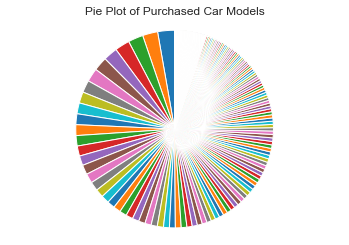

In [453]:
trimmed_raw_df.model.value_counts()
labels = list(trimmed_raw_df.model.value_counts().index)
vals = list(trimmed_raw_df.model.value_counts().values)

fig1, ax1 = plt.subplots()
ax1.pie(vals, labels=labels,startangle=90, labeldistance= None)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Pie Plot of Purchased Car Models')
plt.show()

Looking at the vast multitude of wedges with unequal shape, we can see that predicting the car model will not be viable. A car model that only appears a handful of times in a dataset of 200,000 provides no useful information for training. For example, we cannot say with any confidence that a new customer would buy 'Model X' if we only have one instance of a customer purchasing 'Model X' in our dataset.

The goal of any predictive model is to generalize well with new information, and so with 575 possible classes, this is not possible with `model` as the target.

In [454]:
# Test the feasability of using model as a target
print("Unique appraised vehicle models: ", len(trimmed_raw_df.model_appraisal.unique()))
print("Unique purchased vehicle models: ", len(trimmed_raw_df.model.unique()))

Unique appraised vehicle models:  676
Unique purchased vehicle models:  575


#### Model Training
To look at the feasability of potential models. We will first remove all null-containing rows and generate a model based on that data. We have already looked at null vs non-null rows and determined that there are no eggregious differences between the two. So, after we find a promising model candidate, we can compare different null-handling strategies (dropping, KNN, mean, mode, etc.)

In [455]:
# All null rows dropped previously as 'df_dropped'
print(f'Check number of missing values in dataset with dropped nulls is zero: {df_dropped.isna().sum().sum()==0}')

print(f'Dropping all nulls gives a dataset that is {(trimmed_raw_df.shape[0] - df_dropped.shape[0])/trimmed_raw_df.shape[0]*100:.2f} % smaller than the original.')

# We can use this dataset with dropped nulls to compare against those with imputed values.

# Features that we may want to predict:
pred_feats = ['price', 'mileage', 'make', 'model', 'trim_descrip', 'body', 'color', 'engine', 'cylinders', 'mpg_city', 'mpg_highway', 'horsepower', 'fuel capacity']


Check number of missing values in dataset with dropped nulls is zero: True
Dropping all nulls gives a dataset that is 29.66 % smaller than the original.


In [456]:
# Select numerical and categorical columns
numerical_columns = df_dropped.select_dtypes(include = 'number').columns
categorical_columns = df_dropped.select_dtypes(exclude = 'number').columns.tolist()

# Make new df with dummy columns and scale. Even dummy columns need to be standardized for PCA
scaled_df = pd.get_dummies(df_dropped, columns = categorical_columns)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns = scaled_df.columns)
scaled_df.index = df_dropped.index
print(scaled_df.shape)
scaled_df.head()

(140683, 160)


,price,appraisal_offer,model_year,mileage,engine,cylinders,mpg_city,mpg_highway,horsepower,fuel_capacity,...,market_7,market_8,market_9,market_10,market_11,market_12,market_13,market_14,market_15,market_16
1,-1.007366,-0.942148,-3.229030,2.578635,0.547219,0.717701,-0.615594,-0.402194,0.628835,0.060225,...,-0.275282,-0.298675,-0.27404,-0.272628,3.538829,-0.196243,-0.160756,-0.331325,-0.222128,-0.243426
3,1.045978,-0.431211,0.663310,-0.889513,-0.771487,-0.703577,0.617659,0.846030,0.236154,-0.635814,...,-0.275282,-0.298675,-0.27404,-0.272628,-0.282579,-0.196243,6.220619,-0.331325,-0.222128,-0.243426
4,0.532642,0.590663,-0.796318,-0.048750,-0.331918,-0.703577,-1.026678,-1.115464,0.890622,-0.635814,...,-0.275282,-0.298675,-0.27404,-0.272628,-0.282579,-0.196243,-0.160756,-0.331325,-0.222128,4.108024
5,-1.007366,-0.431211,0.176767,-0.048750,-0.419832,-0.703577,0.617659,1.024348,-0.680101,0.060225,...,-0.275282,-0.298675,-0.27404,3.668001,-0.282579,-0.196243,-0.160756,-0.331325,-0.222128,-0.243426
6,1.045978,2.889879,0.176767,-0.679323,2.920888,2.138978,-1.232220,-0.758829,2.854026,0.292238,...,-0.275282,3.348126,-0.27404,-0.272628,-0.282579,-0.196243,-0.160756,-0.331325,-0.222128,-0.243426


#### PCA Functions

In [457]:
def run_pca(df, n_components):
    """
    Runs Principal Component Analysis on the input df with the n_components passed through to the sklearn PCA function
    :param df:
    :param n_components:
    :return: pca - the PCA instance, pca_matrix - the fit_transform of the df, pca_df_info -
    the dataframe with the explained variance ratio for analysis
    """

    # Create PCA instance
    pca = PCA(n_components = n_components)
    # Fit on df
    pca_matrix = pca.fit_transform(df)
    # number of dimensions
    dims = [i for i in range(1, len(pca.components_)+1)]
    # Create DataFrame from the pca components, because there are fewer components  than
    # original dataframe columns. The column names are not applicable.
    pca_df_info = pd.DataFrame(np.round(pca.components_, 6))
    ratios = np.round(pca.explained_variance_ratio_.reshape(len(pca.components_), 1), 6)
    pca_df_info.insert(1, 'Explained Variance Ratio', ratios)

    return pca, pca_matrix, pca_df_info

def plot_pca(pca):
    '''
    Generates a plot of the individual and cumulative explained variance given a PCA instance
    :param pca:
    :return:
    '''
    cum_sum = np.cumsum(pca.explained_variance_ratio_)

    fig, ax = plt.subplots()
    ax.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,
            alpha=0.5, align = 'center', label = 'Individual explained variance', color = 'c')
    ax.set_xlabel('Principal component No.')
    ax.set_ylabel('Individual explained variance', color = 'c')
    ax2 = ax.twinx()
    ax2.step(range(0, len(cum_sum)),
             cum_sum, where = 'mid', label = 'Cumulative explained variance', color = 'red')
    ax2.set_ylabel('Cumulative explained variance', color = 'red')
    fig.set_size_inches(7,5)
    ax.set_title('Plot of Individual and Cumulative Variances for PCA')
    plt.tight_layout()
    plt.show()

def score_kmeans(data, n_centers):
    '''
    Takes data and number of centroids for kmeans clustering. Returns score.
    :param data:
    :param n_centers:
    :return:
    '''
    kmeans = KMeans(n_clusters=n_centers)

    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score



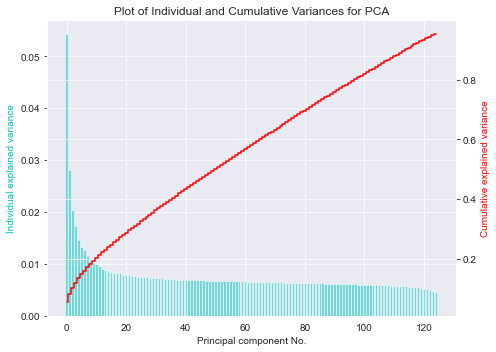

In [458]:
# Run PCA with components explaining 95% of variance
pca, pca_matrix, pca_df_info = run_pca(scaled_df, n_components=.95)
pca_df = pd.DataFrame(pca_matrix)
plot_pca(pca)

In [459]:
pca_df_info.head()

,0,Explained Variance Ratio,1,2,3,4,5,6,7,8,...,150,151,152,153,154,155,156,157,158,159
0,0.222125,0.054205,0.133937,0.012701,0.002426,0.257879,0.251583,-0.247562,-0.252591,0.268886,...,0.013927,-0.010361,0.015196,-0.011702,0.006094,0.006374,-0.004358,-0.003508,-0.003905,-0.002131
1,0.185921,0.028071,0.135727,0.055649,-0.042479,0.180662,0.174895,-0.196971,-0.206359,0.198807,...,-0.003666,0.001468,0.004505,0.008941,-0.000315,-0.002889,0.003583,-0.005586,0.001886,0.002649
2,-0.107936,0.020408,-0.294909,-0.207217,0.202645,0.182114,0.174736,-0.142246,-0.110265,0.117701,...,0.002054,-0.010336,-0.002584,0.008542,-0.002337,0.010161,-0.006881,0.002611,0.002946,-0.008619
3,0.038395,0.017225,0.261512,0.157461,-0.125766,0.011336,0.016540,0.138362,0.158129,0.005907,...,-0.032549,0.057503,0.066415,0.030706,-0.028108,0.022919,-0.026357,-0.038451,0.019272,-0.012186
4,0.062290,0.014608,-0.061098,-0.026674,-0.000525,0.069047,0.071263,0.054851,0.107595,0.089854,...,-0.013763,0.000234,-0.023191,0.052156,-0.022638,-0.003780,-0.013455,0.024282,0.046417,0.020806


Text(0, 0.5, 'PCA Comp 2')

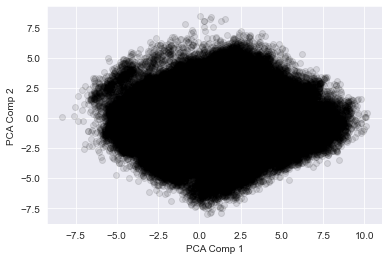

In [460]:
plt.scatter(pca_df[0], pca_df[1], alpha=0.1, color='black')
plt.xlabel('PCA Comp 1')
plt.ylabel('PCA Comp 2')

This plot shows that in the dimensions of PCA Comp 1 and PCA Comp 2, there is little visually apparent clustering.

#### Plot KMeans Clustering with Elbow Method

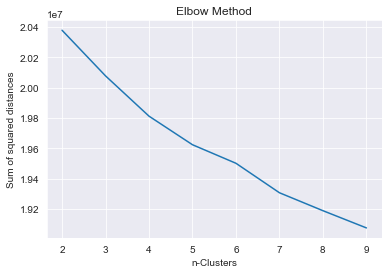

Elapsed time: 29.44 seconds


In [461]:
# plot clusters
scores=[]
Sum_of_squared_distances = []
centers = list(range(2,10))
start_time = time.perf_counter()
for center in centers:
    # New kmeans instance with new number of centers
    kmeans = KMeans(n_clusters=center)
    # Fit using the PCA matrix created
    kmeans.fit(pd.DataFrame(pca_matrix))
    # Add current inertia to Sum_of_squared_distances
    Sum_of_squared_distances.append(kmeans.inertia_)

    # Get labels
    cluster_labels = kmeans.labels_


# Elbow method plotting
plt.plot(centers, Sum_of_squared_distances)
plt.xlabel('n-Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()
end_time = time.perf_counter()
print(f'Elapsed time: {end_time-start_time:.2f} seconds')

The sum of squared distances is immensely high as shown in this plot (we OneHot encoded (dummy encoded) the categorical variables so that all could be mapped with a Euclidean Distance). This could indicate that Kmeans clustering, or clustering in general, may not be the best approach. We will continue with 7 clusters, but 5 may also be a good choice (no clear elbow).

The current version of Kmeans clustering from scikit-learn uses the 'k-means++' initialization by default. This will be sufficient for this clustering problem despite the high dimensionality.

Other methods such as K-prototypes or Gower distance for mixed datasets could also be viable. Additionally, we can use K-modes and binning.



In [462]:
# Re-fit the k-means model with the selected number of clusters (approximate elbow point) and
# obtain cluster predictions for the customer data.

kmeans = KMeans(n_clusters=7, random_state = 42)
kmeans_model = kmeans.fit(pca_matrix)
kmeans_preds = kmeans_model.predict(pca_matrix)

# Create histogram of cluster distribution for customer data
kmeans_clusters = pd.DataFrame (kmeans_preds, columns = ['customers_clusters'])



Text(0.5, 0, 'Count')

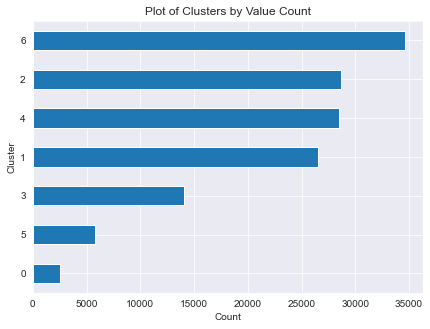

In [463]:
# Plot the cluster counts
bar_plot = kmeans_clusters.customers_clusters.value_counts().sort_values().plot(kind = 'barh', figsize = (7,5));
bar_plot.set_title('Plot of Clusters by Value Count')
bar_plot.set_ylabel('Cluster')
bar_plot.set_xlabel('Count')


In [464]:
# Make a dataframe that contains the original data aligned with what cluster the KMeans algorithm chose for that point
cluster_df = pd.DataFrame(kmeans_preds, columns=['Cluster'])
cluster_df.index = df_dropped.index
print(df_dropped.shape, df_dropped.shape)

cluster_df = df_dropped.join(cluster_df)
cluster_df.head()

(140683, 28) (140683, 28)


,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,trim_descrip,body,color,engine,...,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market,Cluster
1,17.5,2.5,0.0,2006,100.0,KQZ,Premium,E,Silver,3.5,...,D,Gold,4.2,6,16.0,21,205,25.0,11,2
3,37.5,7.5,1.0,2014,17.5,IZA,Premium,F,Silver,2.0,...,F,Blue,3.0,6,17.0,25,230,16.0,13,2
4,32.5,17.5,1.0,2011,37.5,HDT,Premium,F,Blue,2.5,...,E,Black,2.4,4,20.0,29,182,18.0,16,4
5,17.5,7.5,0.0,2013,37.5,OFW,Not Premium,F,White,2.4,...,F,Black,3.6,6,18.0,27,292,19.0,10,1
6,37.5,40.0,0.0,2013,22.5,LTX,Premium,B,Blue,6.2,...,B,Black,6.2,8,16.0,25,455,18.0,8,3


#### Looking at the various customer segments in our dataset

In [465]:
def compare_clusters(df: pd.DataFrame, features, cluster_a : int, rows: int, cols: int):
    """
    Compares a cluster's distribution against the overall distribution of the dataset
    :param df: the DataFrame to use
    :param features: features to compare
    :param cluster_a: cluster number to be compared
    :param rows: passed to subplot function
    :param cols: passed to subplot function
    :return:
    """
    # Null and partial null subset creation
    df_a = df[df['Cluster']==cluster_a]
    # Plot creation for each feature
    fig = plt.figure(figsize=(25, 100), )
    for i, feat in enumerate(features):
        ax = fig.add_subplot(rows, cols, i + 1)
        df_a[feat].hist(bins=75, ax=ax, alpha=0.5, color='green', label=f'Cluster {cluster_a}', density=True)
        df[feat].hist(bins=75, ax=ax, alpha=0.5, color='red', label=f'Total', density=True)
        plt.legend(loc='upper right')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.set_title(f"Cluster {cluster_a} vs Total for {feat}", fontdict={'fontsize': 18})

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.5)
    plt.show()




#### Cluster 0

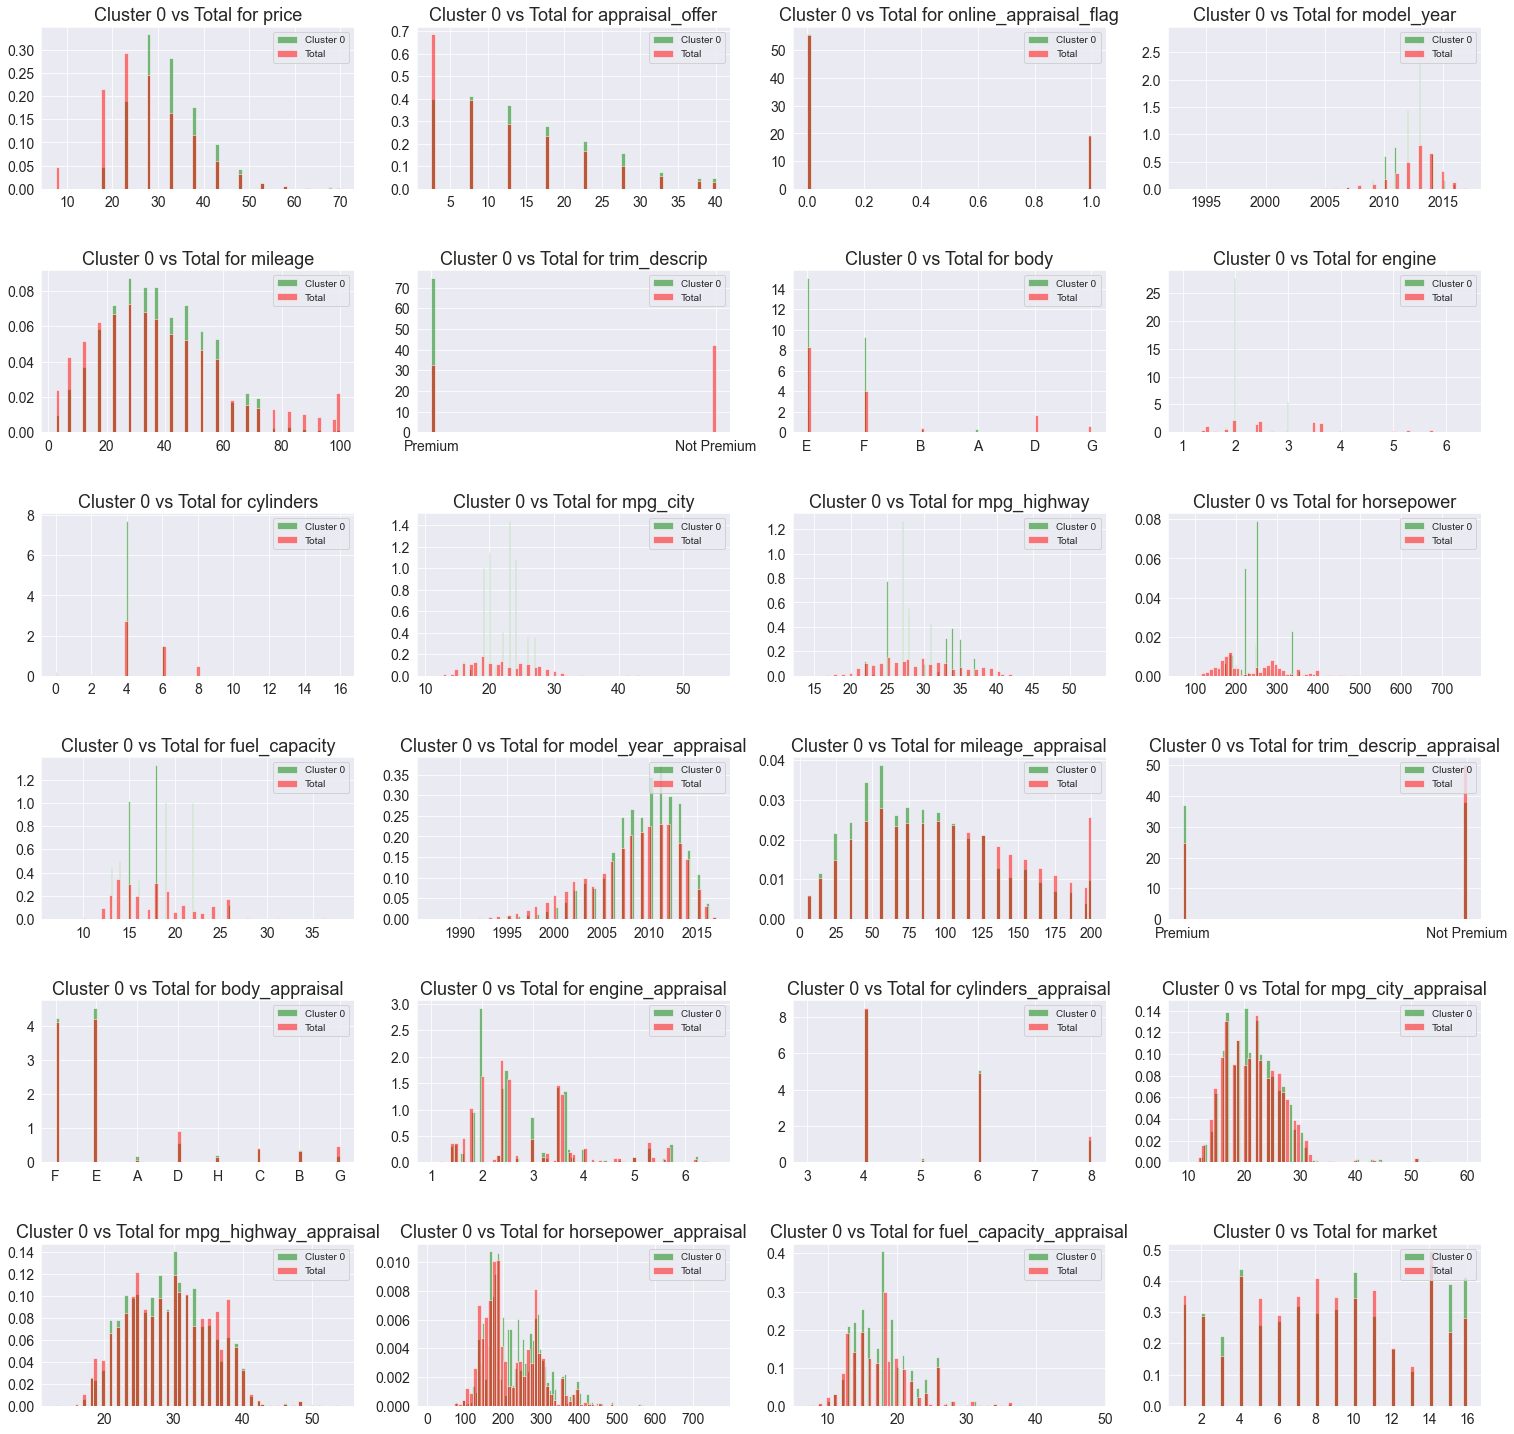

In [466]:
feats = list(trimmed_raw_df.drop(['make', 'make_appraisal', 'model', 'model_appraisal', 'color', 'color_appraisal'],
                                 axis=1).columns)
compare_clusters(cluster_df, feats, 0, len(feats), 4)

Analyzing the differences between cluster 0 and the overall distribution, we can see cluster 0 customers prefer to purchase premium V6 vehicles with an engine size between 3 and 4 liters. Additionally, these customers bring in primarily E and G body vehicles for appraisal. The extreme peaks in the distribution plots for cluster 0 is due to it being the smallest cluster of the seven in the dataset.


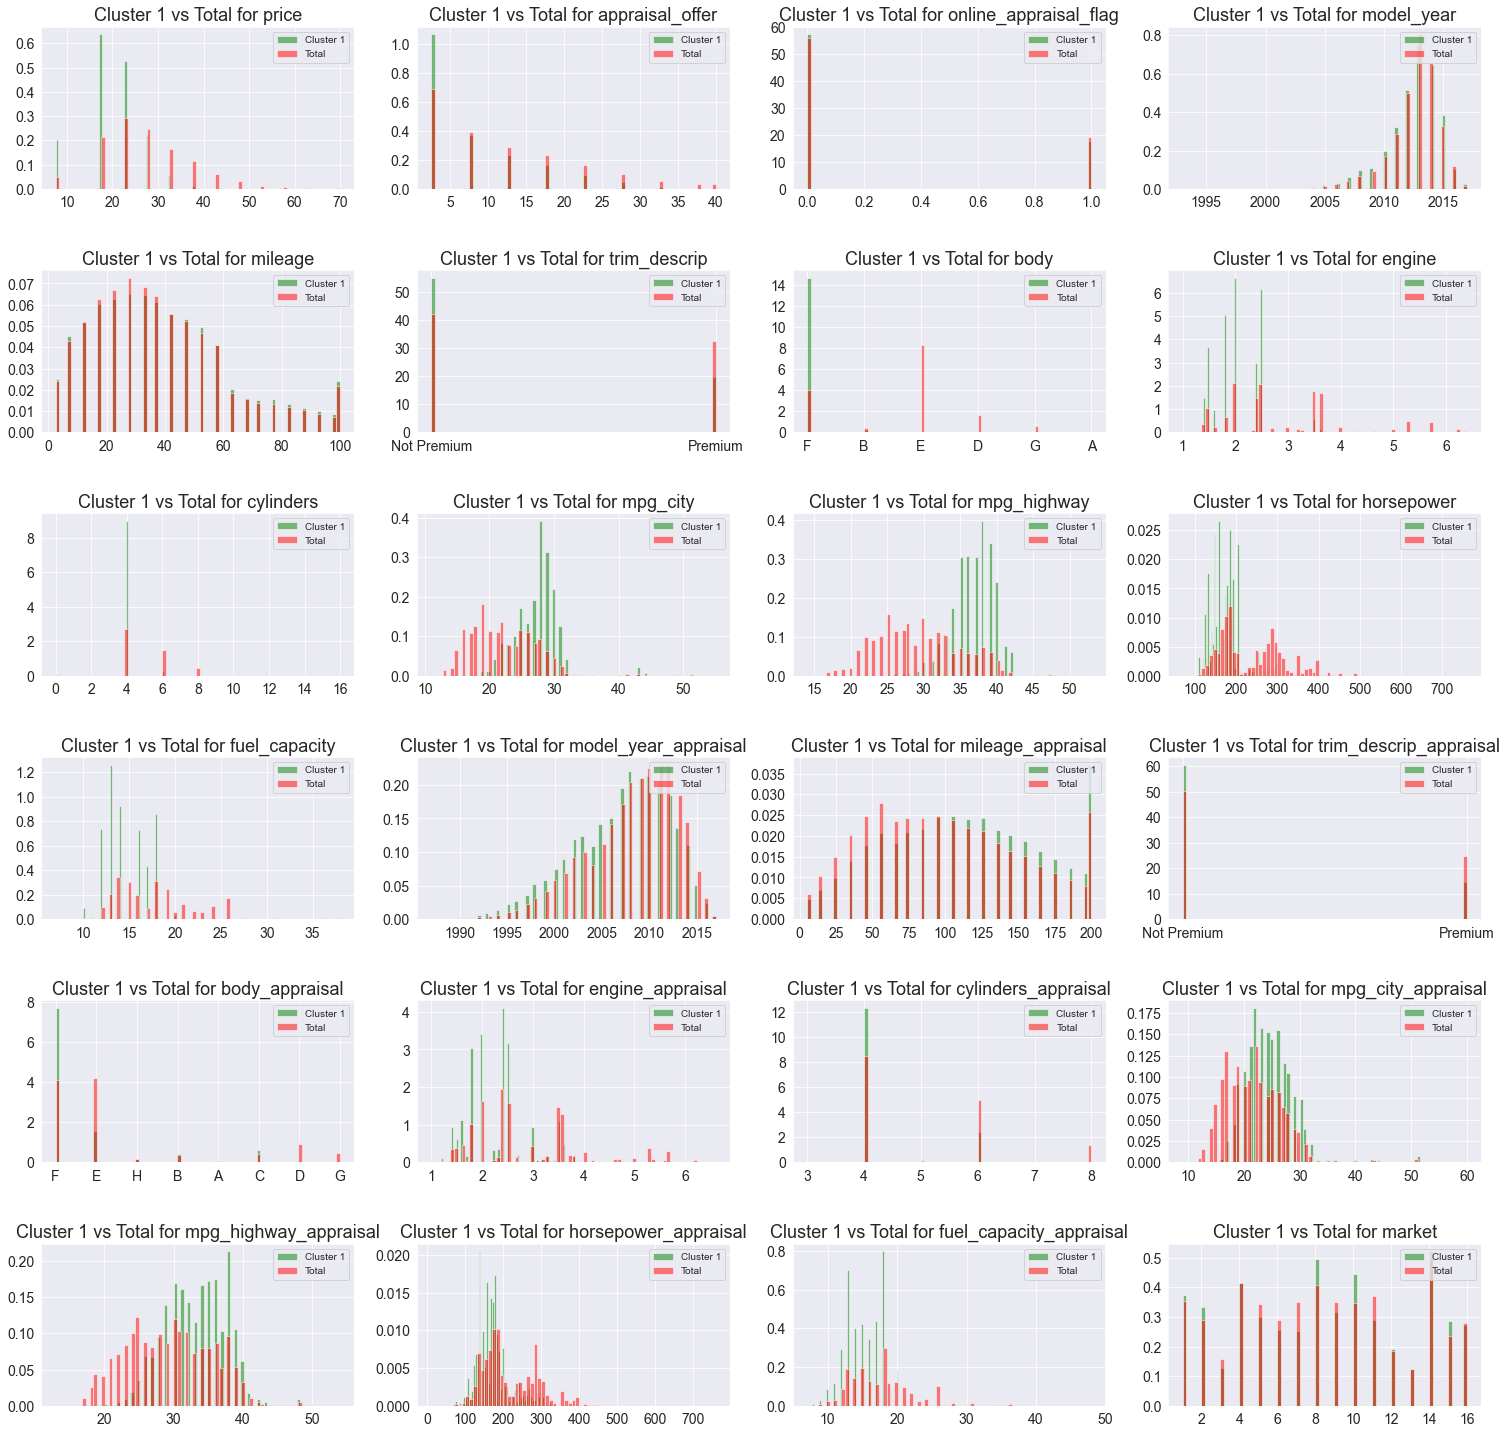

In [467]:
feats = list(trimmed_raw_df.drop(['make', 'make_appraisal', 'model', 'model_appraisal', 'color', 'color_appraisal'],
                                 axis=1).columns)
compare_clusters(cluster_df, feats, 1, len(feats), 4)

Cluster 1 customers prefer to purchase E type V4 vehicles and appraise smaller, more efficient cars.

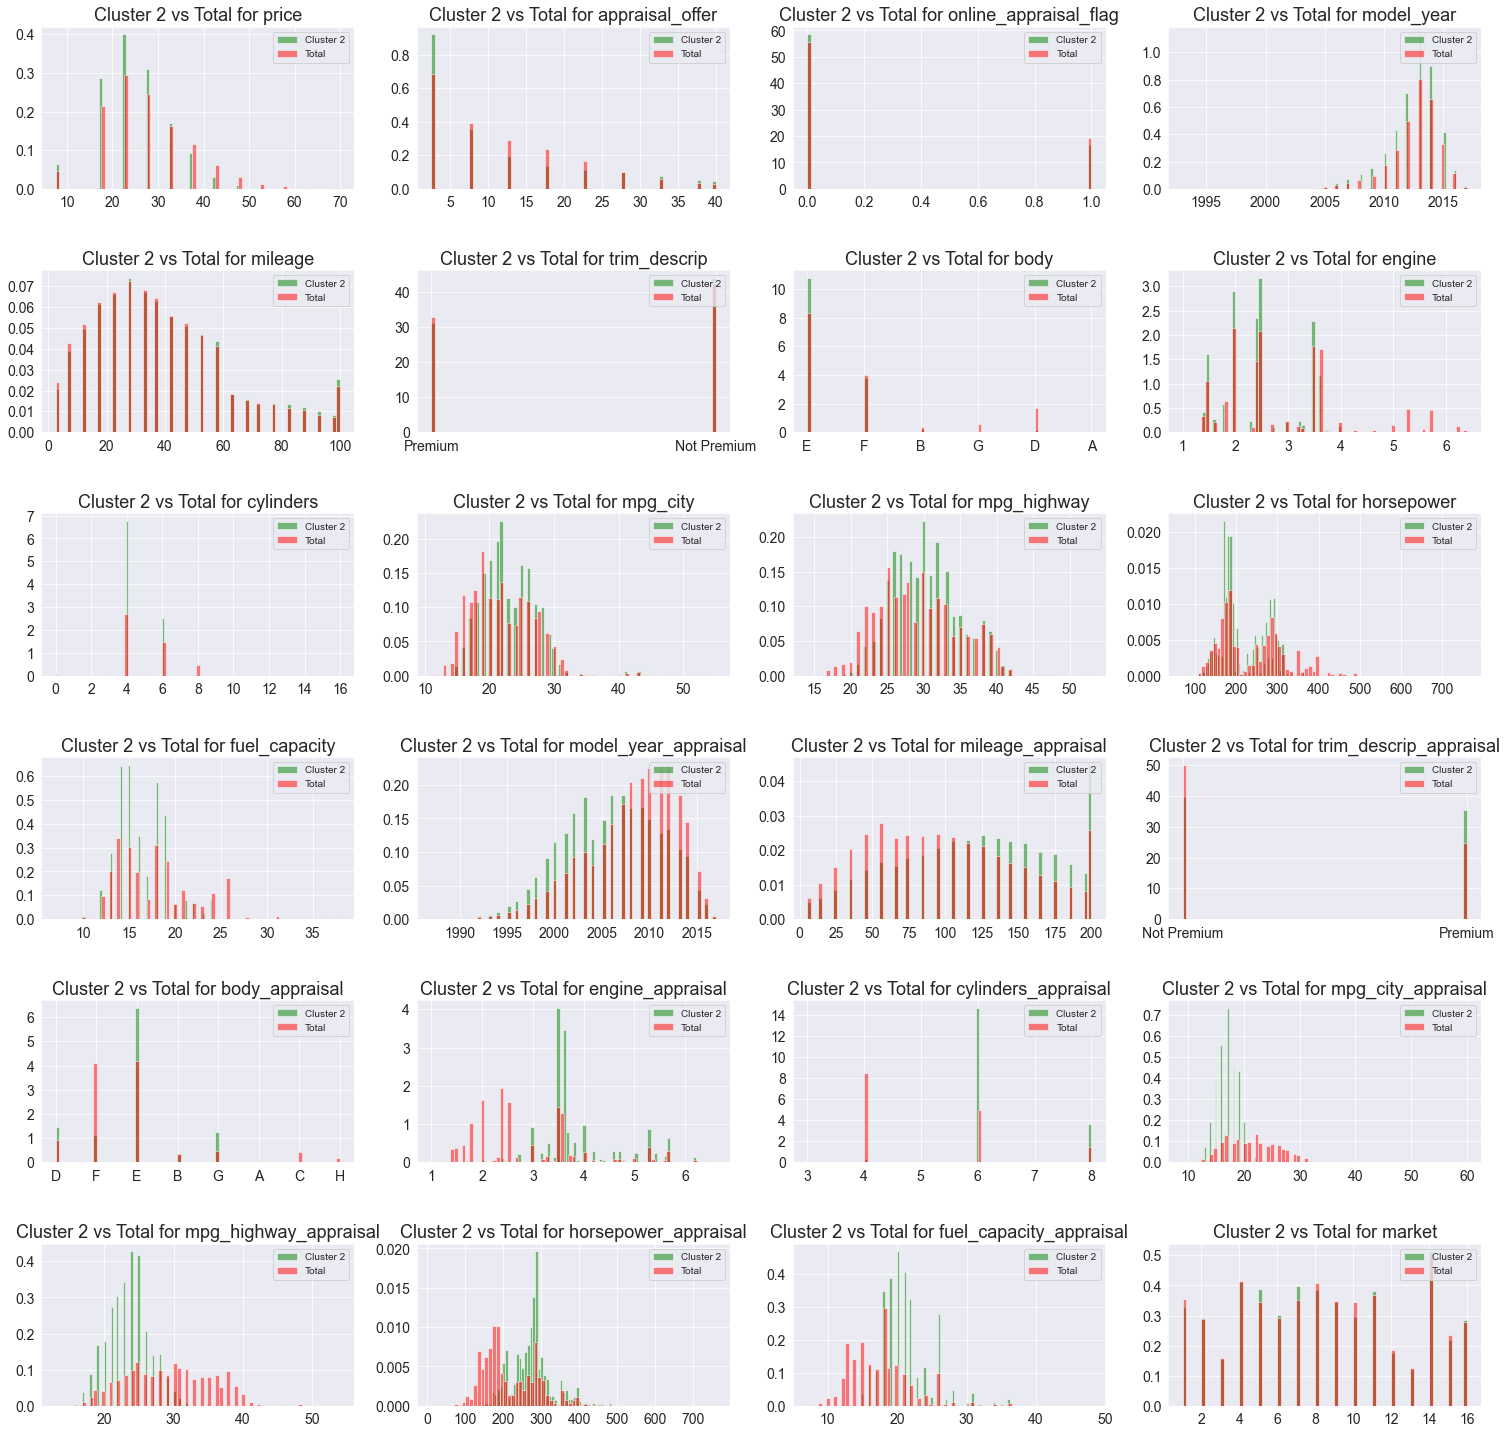

In [468]:
compare_clusters(cluster_df, feats, 2, len(feats), 4)

Cluster 2 customers prefer to purchase more expensive D type vehicles with powerful engines. These vehicle traits are also exhibited in their appraised vehicles.

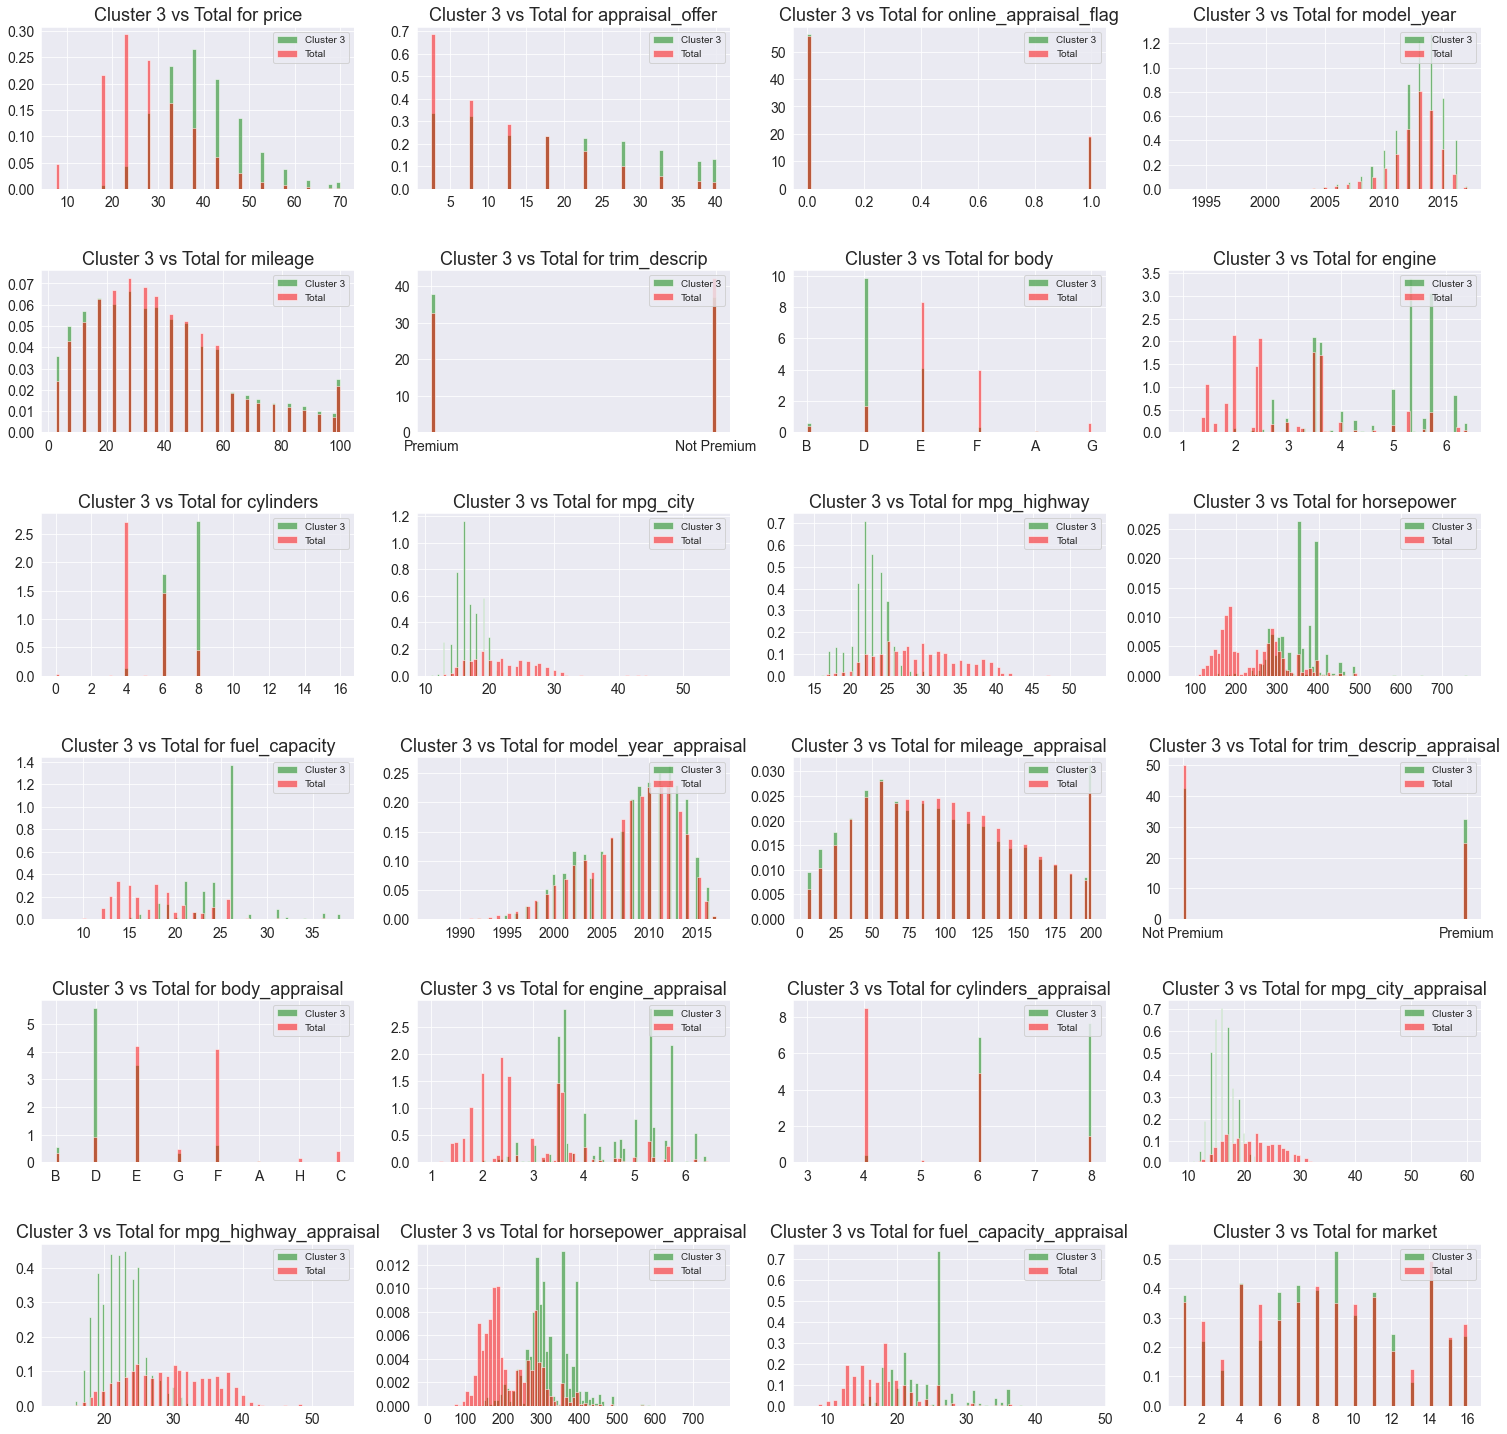

In [469]:
compare_clusters(cluster_df, feats, 3, len(feats), 4)

Cluster 3 customers prefer to purchase slightly more expensive vehicles with larger engines and less efficiency. Interestingly, their appraised vehicles have an average efficiency greater than that of the total dataset

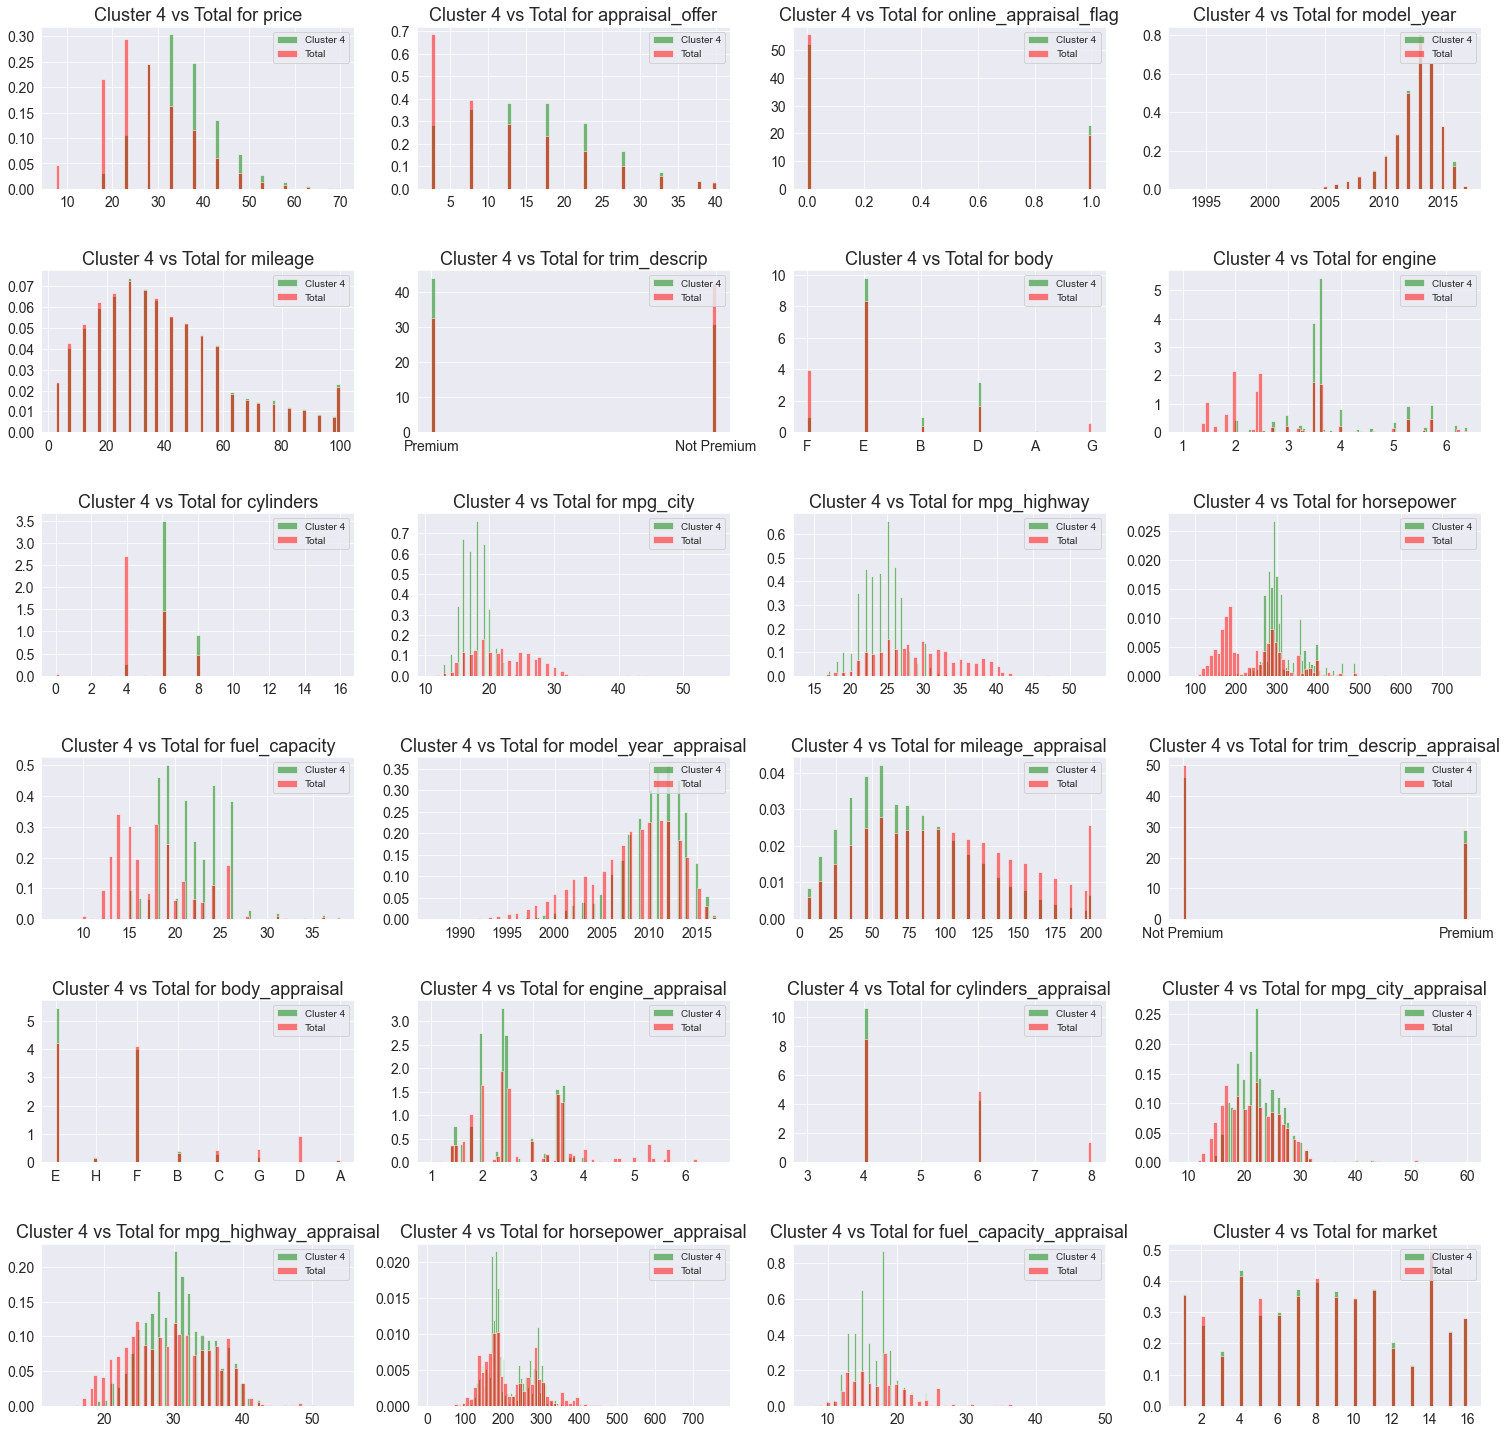

In [470]:
compare_clusters(cluster_df, feats, 4, len(feats), 4)

Cluster 4 customers opt for the E and F body vehicles in their purchases. They also tend to purchase four cylinder vehicles while their appraised vehicle tends to be a V6 or V8.

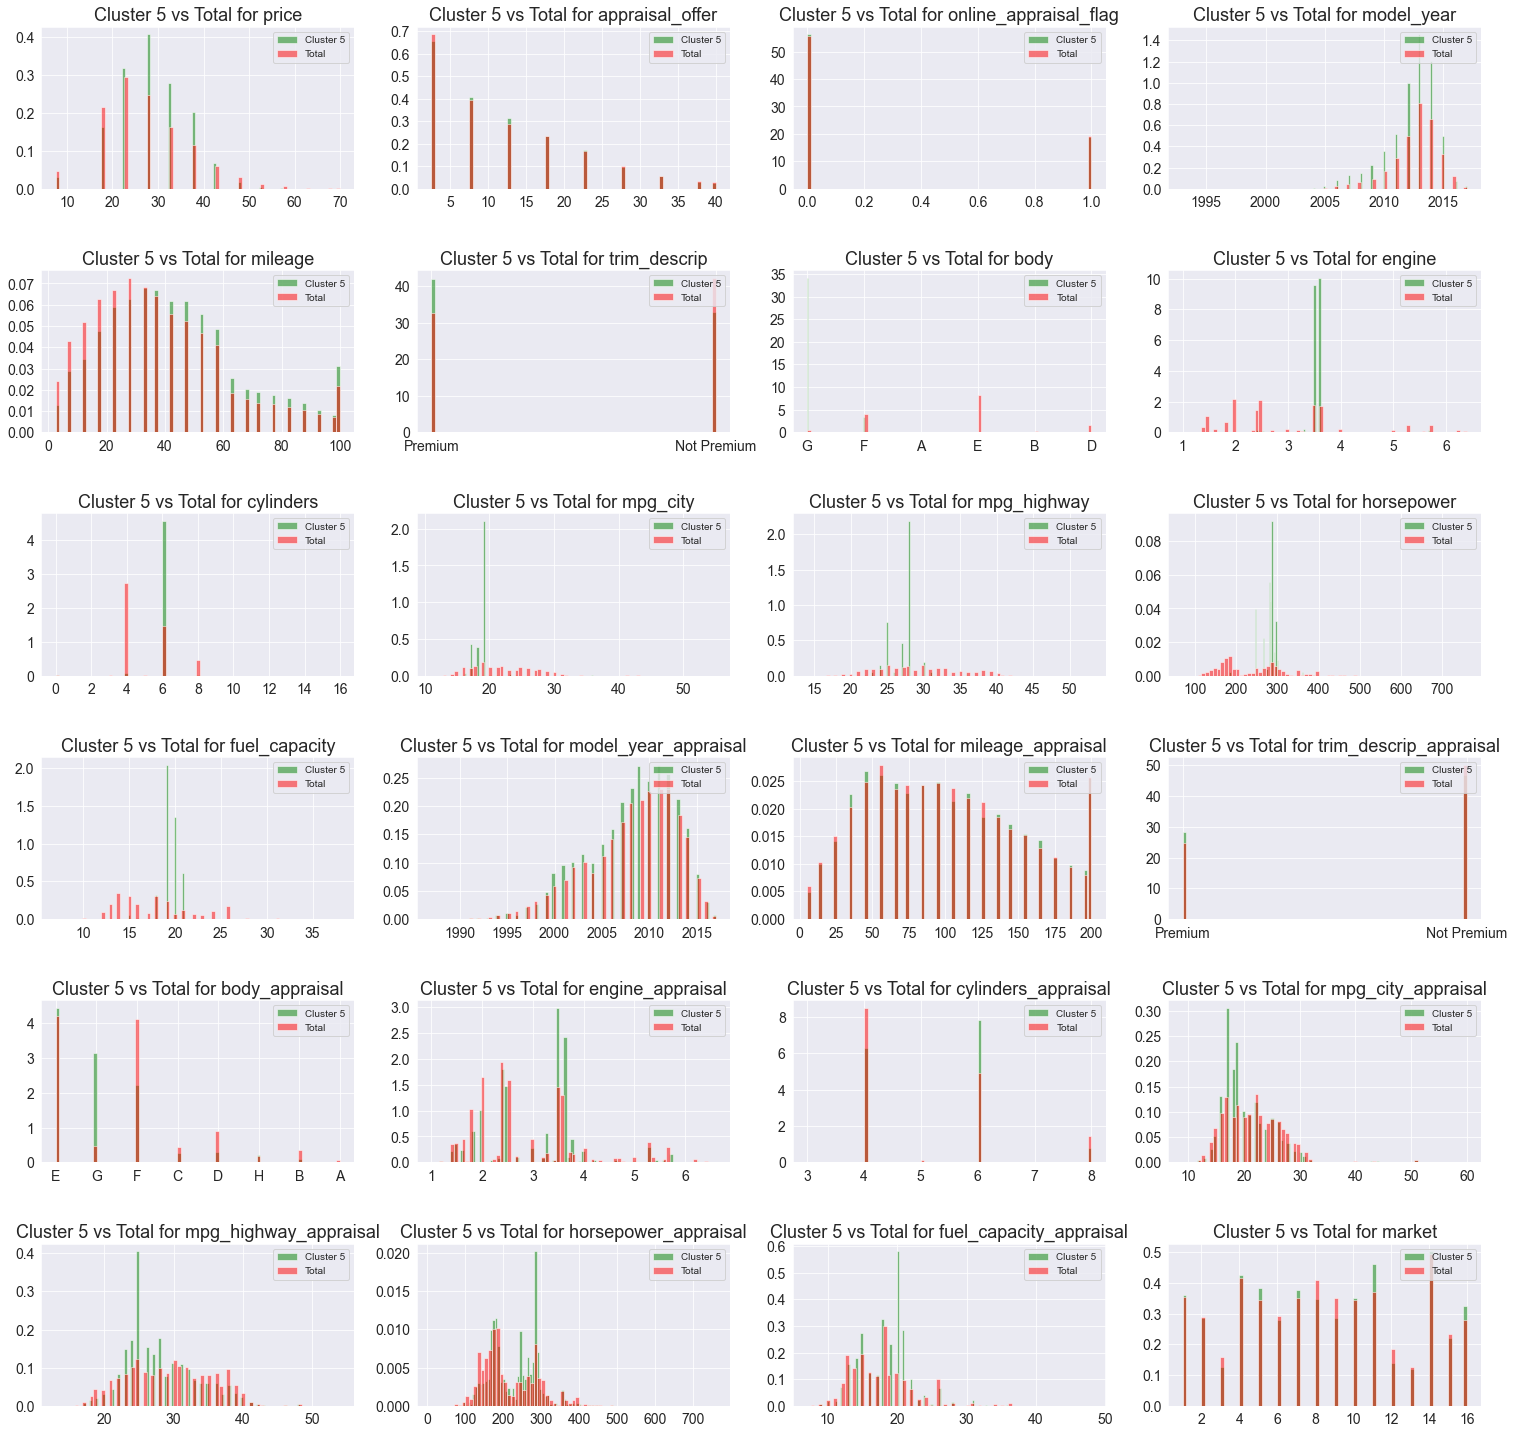

In [471]:
compare_clusters(cluster_df, feats, 5, len(feats), 4)

Cluster 5 customers elect to purchase cheaper, F body vehicles. They also prefer high efficiency, four cylinder vehicles, as shown in their purchased and appraised vehicles.

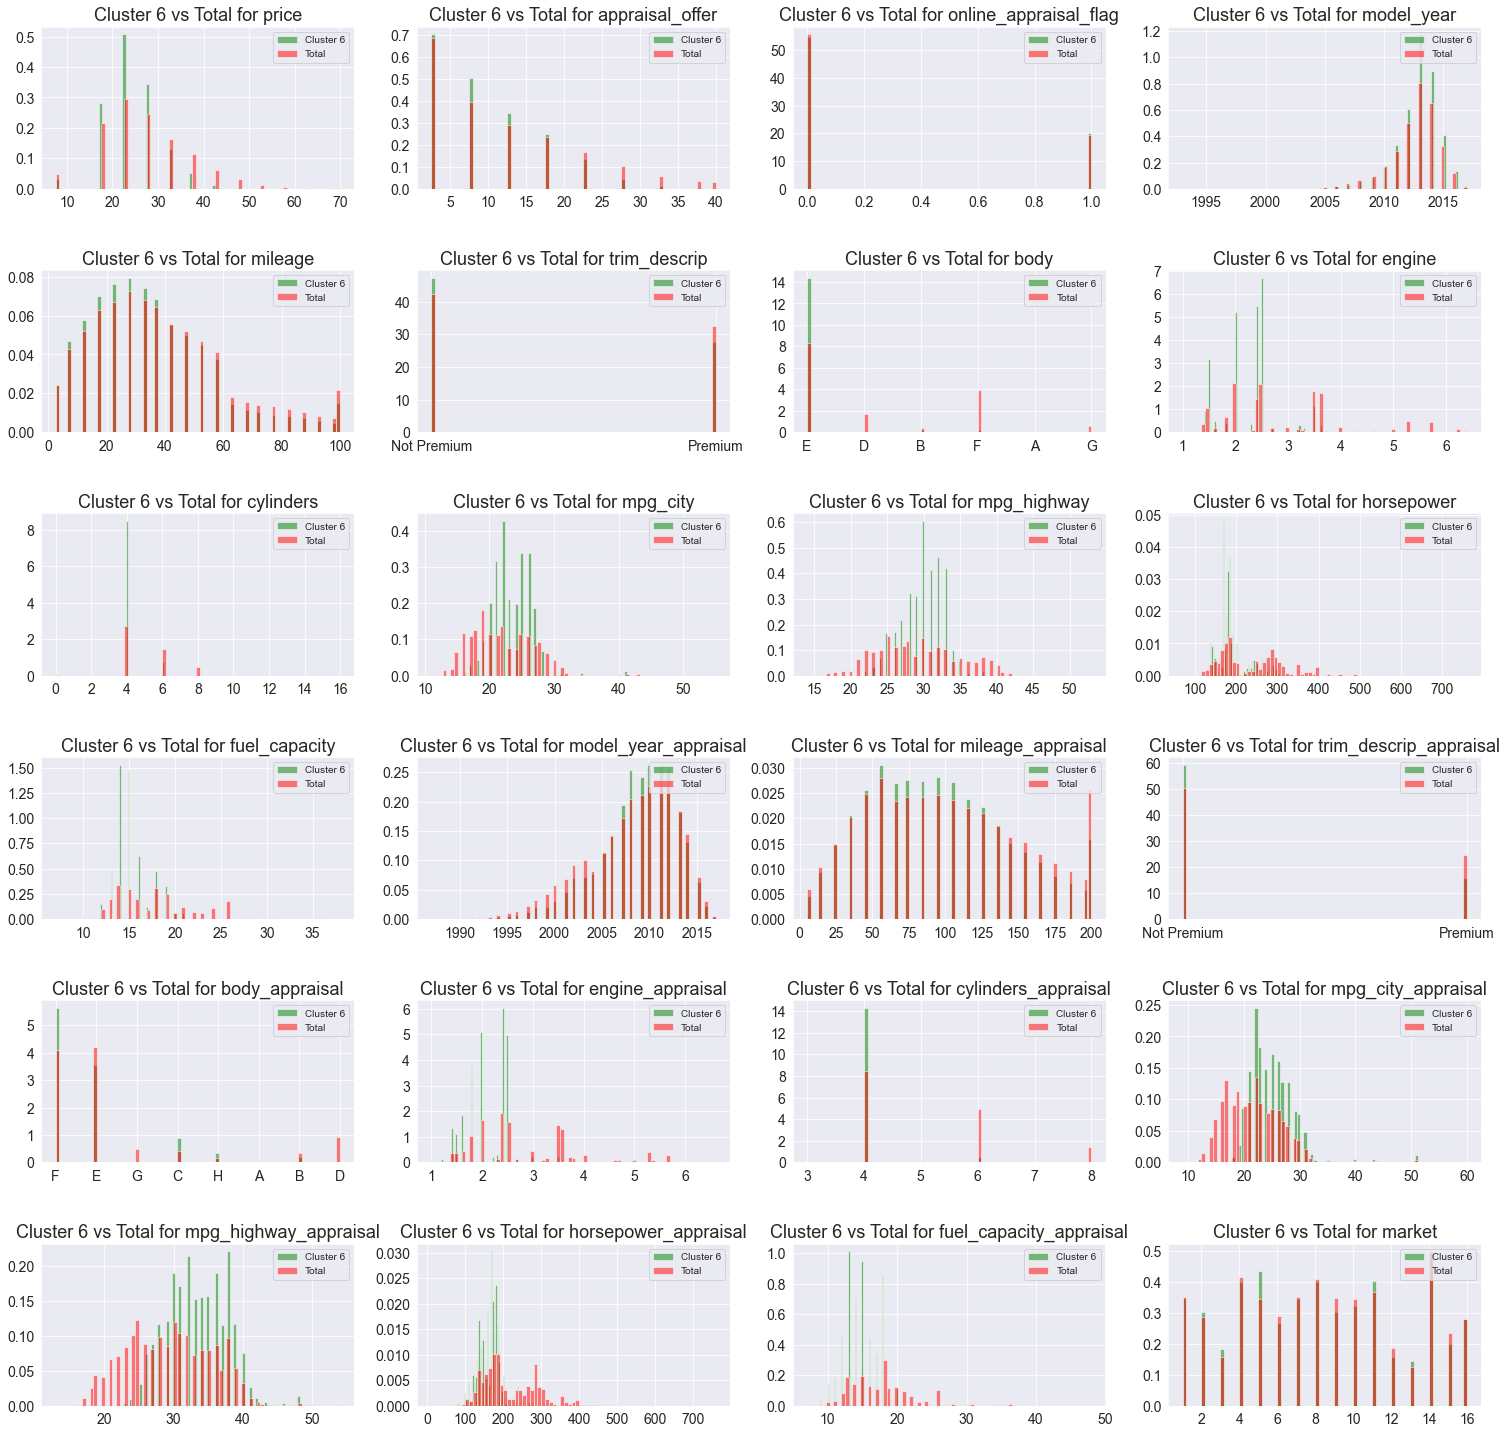

In [472]:
compare_clusters(cluster_df, feats, 6, len(feats), 4)

Finally, cluster 6 customers prefer to purchase premium, more expensive vehicles of body type E. These features also align with their appraised vehicle.

### K-Means with PCA using Numerical Conversion and OneHot Encoding: Conclusion
From a basic k-means clustering analysis with sklearn, its apparent that there are differentiable segments of customers in this data. Additionally, its intuitive that customers can be divided into two generalized samples for their purchased vehicles: more efficient/lower power and less efficient/higher power.

However, looking at the sum of squared distances (SSE/inertia). This kmeans approach with dimensionality reduction  and one-hot encoding may not be the optimal method, especially because we cannot compare with ground truth customer differentiators.

One tactic we can employ with this cluster data is looking at how new customers align with the appraised vehicle  attributes of one of the clusters.

Ex. If Customer A's vehicle aligns with the distribution of Cluster 1's appraised features, we can estimate that they will opt to purchase a vehicle that falls within the distribution of Cluster A's purchased vehicle attributes.

While this is not an entirely accuracy-focused strategy, it still allows for CarMax to get a general idea of what vehicles a customer might like to browse or test drive, perhaps before they get on site. This would save time and resources for both CarMax and the customer.

#### Clustering with Kmodes and Discretization

For previous analyses, the some of the discretized data columns were converted to numerical. For a KModes approach, these bins for otherwise numerical data can stay as bins (price or mileage ranges).

In [473]:
# Discretization Approach

# Adjusting original optimization schema
schema['mileage'] = 'category'
schema['mileage_appraisal'] = 'category'
schema['price'] = 'category'
schema['appraisal_offer'] = 'category'

# Reload data
disc_df = pd.read_csv("./Data/ShowcaseDataWinter2023.csv")
# Clean Engine cols
disc_df = clean_engine(disc_df)
# Apply optimization schema
disc_df = disc_df.astype(schema)

In [474]:
disc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    200000 non-null  category
 1   appraisal_offer          200000 non-null  category
 2   online_appraisal_flag    196166 non-null  category
 3   model_year               200000 non-null  int32   
 4   mileage                  200000 non-null  category
 5   make                     200000 non-null  category
 6   model                    200000 non-null  object  
 7   trim_descrip             176159 non-null  category
 8   body                     189741 non-null  category
 9   color                    199967 non-null  category
 10  engine                   199999 non-null  float32 
 11  cylinders                200000 non-null  int16   
 12  mpg_city                 199410 non-null  float64 
 13  mpg_highway              199410 non-null  fl

In [475]:
# The below method is permitted for use by the creator, Ekeany, under the MIT License.
# See https://github.com/Ekeany/Clustering-Mixed-Data/blob/main/LICENSE for details.
def get_knn_bins(df, cols, bins=5, drop_cols=True):

    for col in cols:

        kmeans  = KMeans(n_clusters=bins).fit(df[col].to_frame().values.reshape(-1,1))
        results = pd.DataFrame(kmeans.labels_, columns=[col + '_centroid'])

        df = df.reset_index()
        df[col + '_centroid'] = results[col + '_centroid']

        knn_bin_df = pd.DataFrame(kmeans.cluster_centers_)
        knn_bin_df = knn_bin_df.astype(int).reset_index()

        temp_df = pd.merge(df[col + '_centroid'],
                           knn_bin_df,
                           left_on=col + '_centroid',
                           right_on='index',
                           how='left')

        # rename empty column header 0 -> column_name value
        temp_df = temp_df.rename(columns={0:col+'_value'})

        temp_df.loc[:,col+'_value'] = col + '_' + temp_df[col+'_value'].astype(str)

        df = pd.concat([df, temp_df[col+'_value']], axis=1)
        df.drop([col + '_centroid', 'index'], axis=1, inplace=True)


        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.hist(df[col].values, bins=50)
        ax1.set_title('Histogram of ' + col)

        # produce the second bar chart need the centroids and sort values to make bar chart
        # resemble the original distribution.
        Count_Bins = temp_df[col + '_value'].value_counts().rename_axis('bins').reset_index(name='counts')
        extract_number = Count_Bins.bins.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
        extract_number.columns = ['Text', 'Number']
        Count_Bins['bin_centroid'] = extract_number['Number']
        Count_Bins.sort_values(by=['bin_centroid'], ascending=True, inplace=True)

        ax2.bar(Count_Bins.iloc[:, 0], Count_Bins.iloc[:, 1])
        ax2.set_title('Bar Chart of ' + col + ' Binned')
        ax2.tick_params(labelrotation=90)

        plt.show()
        plt.tight_layout()


    if drop_cols:
        return df.drop(cols, axis=1)

    else:
        return df

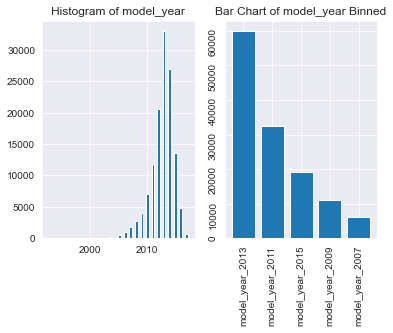

<Figure size 432x288 with 0 Axes>

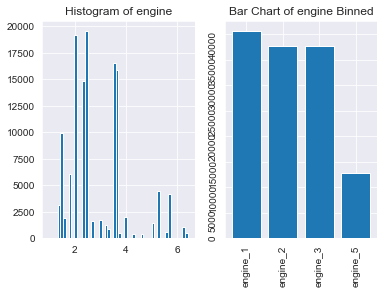

<Figure size 432x288 with 0 Axes>

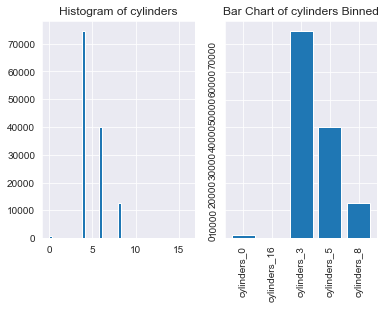

<Figure size 432x288 with 0 Axes>

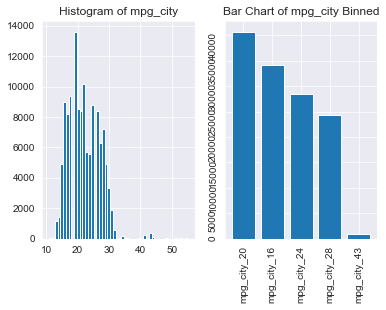

<Figure size 432x288 with 0 Axes>

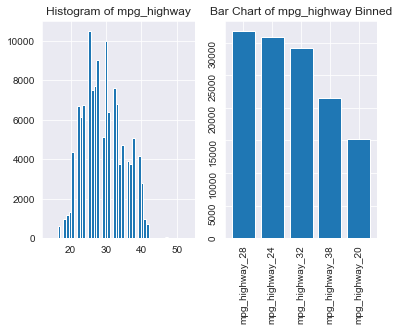

<Figure size 432x288 with 0 Axes>

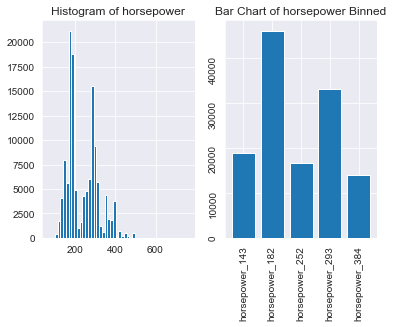

<Figure size 432x288 with 0 Axes>

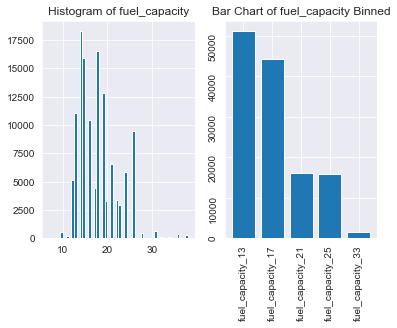

<Figure size 432x288 with 0 Axes>

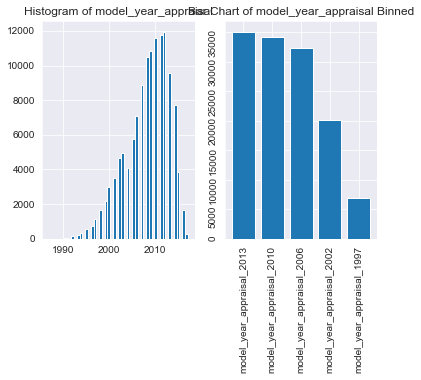

<Figure size 432x288 with 0 Axes>

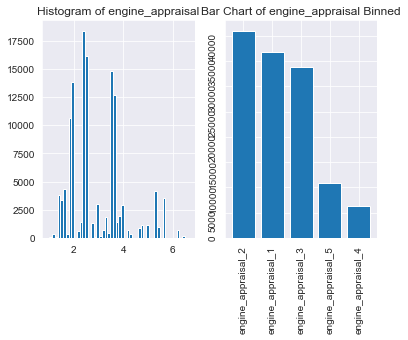

<Figure size 432x288 with 0 Axes>

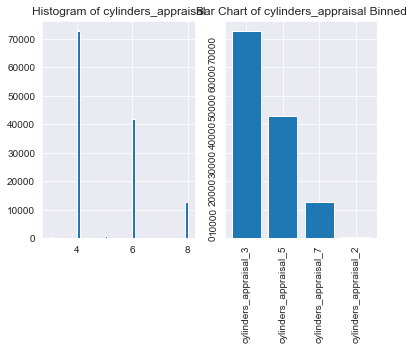

<Figure size 432x288 with 0 Axes>

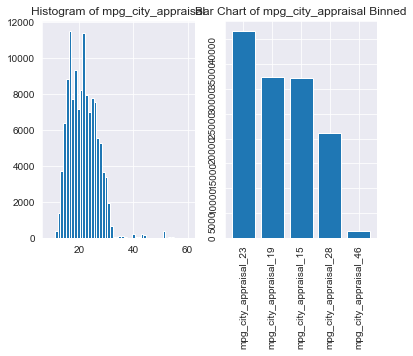

<Figure size 432x288 with 0 Axes>

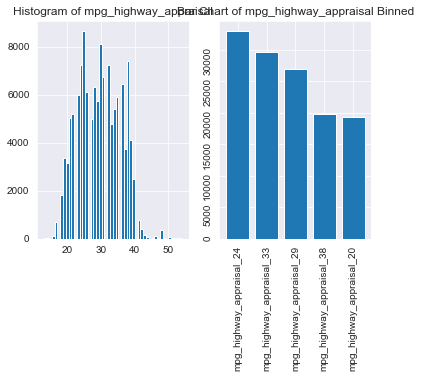

<Figure size 432x288 with 0 Axes>

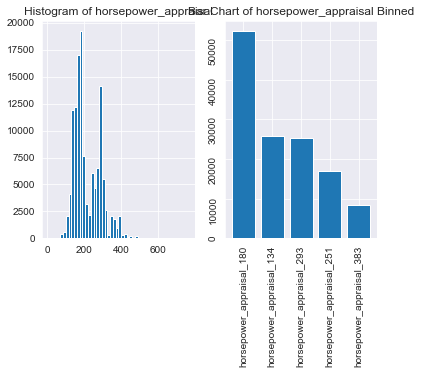

<Figure size 432x288 with 0 Axes>

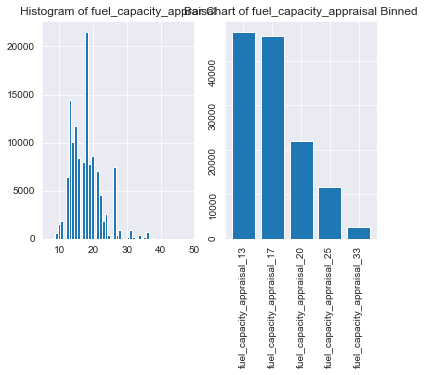

,price,appraisal_offer,online_appraisal_flag,mileage,make,model,trim_descrip,body,color,mileage_appraisal,...,mpg_highway_value,horsepower_value,fuel_capacity_value,model_year_appraisal_value,engine_appraisal_value,cylinders_appraisal_value,mpg_city_appraisal_value,mpg_highway_appraisal_value,horsepower_appraisal_value,fuel_capacity_appraisal_value
0,$15k to $20k,$0k to $5k,0.0,100k+ miles,KQZ,KQZ_23,Premium,E,Silver,0 to 10k miles,...,mpg_highway_28,horsepower_293,fuel_capacity_17,model_year_appraisal_1997,engine_appraisal_4,cylinders_appraisal_5,mpg_city_appraisal_15,mpg_highway_appraisal_20,horsepower_appraisal_180,fuel_capacity_appraisal_25
1,$30k to $35k,$15k to $20k,1.0,35k to 40k miles,HDT,HDT_8,Premium,F,Blue,20k to 30k miles,...,mpg_highway_24,horsepower_293,fuel_capacity_13,model_year_appraisal_2010,engine_appraisal_2,cylinders_appraisal_3,mpg_city_appraisal_19,mpg_highway_appraisal_29,horsepower_appraisal_180,fuel_capacity_appraisal_17
2,$15k to $20k,$5k to $10k,0.0,35k to 40k miles,OFW,OFW_11,Not Premium,F,White,160k to 170k miles,...,mpg_highway_32,horsepower_182,fuel_capacity_17,model_year_appraisal_2010,engine_appraisal_3,cylinders_appraisal_5,mpg_city_appraisal_19,mpg_highway_appraisal_24,horsepower_appraisal_293,fuel_capacity_appraisal_17
3,$35k to $40k,$40k+,0.0,20k to 25k miles,LTX,LTX_21,Premium,B,Blue,30k to 40k miles,...,mpg_highway_24,horsepower_384,fuel_capacity_17,model_year_appraisal_2013,engine_appraisal_5,cylinders_appraisal_7,mpg_city_appraisal_15,mpg_highway_appraisal_24,horsepower_appraisal_383,fuel_capacity_appraisal_17
4,$15k to $20k,$5k to $10k,0.0,30k to 35k miles,LTX,LTX_30,Not Premium,E,Black,80k to 90k miles,...,mpg_highway_28,horsepower_143,fuel_capacity_13,model_year_appraisal_2010,engine_appraisal_1,cylinders_appraisal_3,mpg_city_appraisal_28,mpg_highway_appraisal_38,horsepower_appraisal_134,fuel_capacity_appraisal_13


<Figure size 432x288 with 0 Axes>

In [476]:
numerical_columns = disc_df.select_dtypes(include = 'number').columns
categorical_columns = disc_df.select_dtypes(exclude = 'number').columns

recoded_df = get_knn_bins(disc_df.dropna(), numerical_columns, bins=5)
recoded_df.head()

In [477]:
# The below method is permitted for use by the creator, Ekeany, under the MIT License.
# See https://github.com/Ekeany/Clustering-Mixed-Data/blob/main/LICENSE for details.
def column_index(df, query_cols):
    '''
    returns the indices of the query_cols
    '''
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]


cat_cols = recoded_df.select_dtypes(include='object')
categorical_indices = column_index(recoded_df, cat_cols.columns)
categorical = list(categorical_indices)




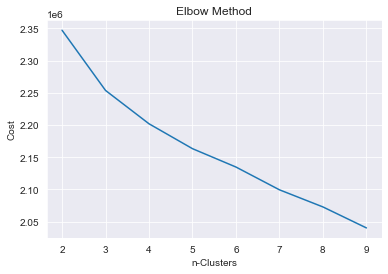

Elapsed time: 541.59 seconds


In [478]:
costs=[]
centers = list(range(2,10))
start_time = time.perf_counter()
for center in centers:
    # New kmodes instance with new number of centers
    kmodes = KModes(verbose=0,
                    n_clusters=center,
                    init='Cao',
                    random_state=42)
    # Fit
    kmodes_clusters = kmodes.fit_predict(recoded_df, categorical=categorical)

    # Add current cost to costs
    costs.append(kmodes.cost_)


# Elbow method plotting
plt.plot(centers, costs)
plt.xlabel('n-Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()
end_time = time.perf_counter()
print(f'Elapsed time: {end_time-start_time:.2f} seconds')

This method produces a plot with an elbow at 5 clusters. Due to the similarity to the previous clustering method and the high distance cost, we can move on from analyzing these clusters to predictive modeling (supervised learning).

In [479]:
# Re-initialize with 5 clusters
kmodes = KModes(verbose=1,
                n_clusters=5,
                random_state=42)

kmodes_clusters = kmodes.fit_predict(recoded_df, categorical=categorical)
labels = kmodes.labels_
adj_mut_info = adjusted_mutual_info_score(labels, kmodes_clusters, average_method='arithmetic')
adj_rand = adjusted_rand_score(labels, kmodes_clusters)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25105, cost: 2163285.0
Run 1, iteration: 2/100, moves: 4028, cost: 2163285.0


In [480]:
# Create dataframe with clusters added
cluster_df = pd.DataFrame(kmodes_clusters, columns=['Cluster'])
cluster_df.index = recoded_df.index
print(recoded_df.shape)

cluster_df = recoded_df.join(cluster_df)
cluster_df.head()

(128683, 30)


,price,appraisal_offer,online_appraisal_flag,mileage,make,model,trim_descrip,body,color,mileage_appraisal,...,horsepower_value,fuel_capacity_value,model_year_appraisal_value,engine_appraisal_value,cylinders_appraisal_value,mpg_city_appraisal_value,mpg_highway_appraisal_value,horsepower_appraisal_value,fuel_capacity_appraisal_value,Cluster
0,$15k to $20k,$0k to $5k,0.0,100k+ miles,KQZ,KQZ_23,Premium,E,Silver,0 to 10k miles,...,horsepower_293,fuel_capacity_17,model_year_appraisal_1997,engine_appraisal_4,cylinders_appraisal_5,mpg_city_appraisal_15,mpg_highway_appraisal_20,horsepower_appraisal_180,fuel_capacity_appraisal_25,1
1,$30k to $35k,$15k to $20k,1.0,35k to 40k miles,HDT,HDT_8,Premium,F,Blue,20k to 30k miles,...,horsepower_293,fuel_capacity_13,model_year_appraisal_2010,engine_appraisal_2,cylinders_appraisal_3,mpg_city_appraisal_19,mpg_highway_appraisal_29,horsepower_appraisal_180,fuel_capacity_appraisal_17,1
2,$15k to $20k,$5k to $10k,0.0,35k to 40k miles,OFW,OFW_11,Not Premium,F,White,160k to 170k miles,...,horsepower_182,fuel_capacity_17,model_year_appraisal_2010,engine_appraisal_3,cylinders_appraisal_5,mpg_city_appraisal_19,mpg_highway_appraisal_24,horsepower_appraisal_293,fuel_capacity_appraisal_17,3
3,$35k to $40k,$40k+,0.0,20k to 25k miles,LTX,LTX_21,Premium,B,Blue,30k to 40k miles,...,horsepower_384,fuel_capacity_17,model_year_appraisal_2013,engine_appraisal_5,cylinders_appraisal_7,mpg_city_appraisal_15,mpg_highway_appraisal_24,horsepower_appraisal_383,fuel_capacity_appraisal_17,1
4,$15k to $20k,$5k to $10k,0.0,30k to 35k miles,LTX,LTX_30,Not Premium,E,Black,80k to 90k miles,...,horsepower_143,fuel_capacity_13,model_year_appraisal_2010,engine_appraisal_1,cylinders_appraisal_3,mpg_city_appraisal_28,mpg_highway_appraisal_38,horsepower_appraisal_134,fuel_capacity_appraisal_13,2


In [481]:
def prep_df(df, target_feats):
    """
    Takes a df and desired target feats and preps the df for classification/regression by
    removing unwanted features/columns
    :param df:
    :param target_feats:
    :return: prepped_df
    """

    #Prep for multi-class
    # Training features initialization. These are feats that contain 'appraisal' and the market feat.
    training_feats = [item for item in df.columns if item.find('appraisal') != -1]
    # Add 'market'
    training_feats.append('market')

    # Define total feats as training_feats combined with target_feats
    total_feats = training_feats + target_feats
    # Drop all columns that are not part of the total scope of features we are using.
    # In this case, that consists of the purchased vehicle traits that are not targets
    drop_feats = [col for col in df.columns if (col not in total_feats)]
    df.drop(drop_feats, axis = 1, inplace=True)

    return df

In [482]:
# Multi - output
start_time = time.perf_counter()
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Prep for multi-class=
# Make a deep copy of the df_dropped DataFrame
multi_class_df = df_dropped.copy(deep = True)

# Define target features
target_feats = ['body', 'trim_descrip']
# Prep df using custom function
multi_class_df = prep_df(multi_class_df, target_feats=target_feats)


# Make a new df that contains OneHot Encoding for the categorical, non-target features
multi_class_df = pd.get_dummies(multi_class_df, columns = ['color_appraisal', 'body_appraisal', 'market',
                                                  'trim_descrip_appraisal', 'make_appraisal',
                                                  'online_appraisal_flag'])

# Training feats are all features except the target feats
training_feats = list(multi_class_df.drop(target_feats, axis=1).columns)

# Define X and y
X = multi_class_df.loc[:, training_feats]
y = multi_class_df.loc[:, target_feats]

# Train, test split with stratification.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.33,
                                                    random_state=42,
                                                    stratify=y)

# initialize new scaler instance
scaler = StandardScaler()

# Define the scaler as a pipeline step
standard_transformer = Pipeline(steps=[
    ('standard', StandardScaler())])

# Column transformer to standardize the training features only, while the rest are passthrough
preprocessor = ColumnTransformer(
    remainder='passthrough', #passthough features not listed
    transformers=[
        ('std', standard_transformer , training_feats)
    ])

# Fit and transform X_train, but only transform X_test to prevent data leakage.
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Create, fit, and score our multi-out classifier. We will use RandomForestClassifier due to the
# high dimensionality of the dataset.
mo_clf = MultiOutputClassifier(RandomForestClassifier(random_state=42)).fit(X_train, y_train)

mo_clf_accuracy_score = mo_clf.score(X_test, y_test)
print(f'Time for multi-out classification cell execution: {time.perf_counter()-start_time:.2f} s')
print(f'Average accuracy score for RFC multi-out classifier for {target_feats}: {mo_clf_accuracy_score:.2f}')



Time for multi-out classification cell execution: 33.81 s
Average accuracy score for RFC multi-out classifier for ['body', 'trim_descrip']: 0.34


The purpose of creating this multiclass output was to determine if an 'ideal' scenario was possible in which we could accurately find all the attributes in a customer's purchased car.

Both through logical reasoning and the above model we can see this is not the case. While the model performs better than random guessing (1/6 * 1/2 * 100 = 8.3% chance of getting the correct combination), it would not be helpful in determining a customer's desired vehicle. Additionally, we know that we are working with data based on human decisions, which, logically, is not perfectly predictable. Countless factors affect an individual's purchasing decisions, and all these factors cannot be mathematically modeled in a simple database.

From these findings, we can aim to predict generalized purchasing tendencies or focus on specific features.



### Individual Feature Prediction

Can we predict individual features well enough to be helpful in a customer's vehicle purchasing process? Let's try predicting car body based on the an appraised vehicle's attributes. Car body would be a useful piece of information for CarMax to hone in on a customer's desired type of vehicle (sedan, SUV, cross-over, truck, sport, etc.)

#### DataFrame Preparation for Classification

In [483]:

# Make new df for individual classification
ind_df = df_dropped.copy(deep=True)

# Define target feat(s)
target_feats = ['body']
# Prep df with custom function
ind_df = prep_df(ind_df, target_feats=target_feats)

ind_df = pd.get_dummies(ind_df, columns = ['color_appraisal', 'body_appraisal', 'market',
                                                           'trim_descrip_appraisal', 'make_appraisal',
                                                           'online_appraisal_flag'])

# Get training features after making dummies
training_feats = list(ind_df.drop(target_feats, axis=1).columns)

scaler = StandardScaler()

standard_transformer = Pipeline(steps=[
    ('standard', StandardScaler())])

preprocessor = ColumnTransformer(
    remainder='passthrough', #passthough features not listed
    transformers=[
        ('std', standard_transformer , training_feats)
    ])
# Train test split
X = ind_df.loc[:, training_feats]
y = ind_df.loc[:, target_feats]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42,
                                                    stratify=y)

# Fit the scaler on X_train and transform both X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Take a look at the df
ind_df.head()

,appraisal_offer,body,model_year_appraisal,mileage_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,...,make_appraisal_LTX,make_appraisal_LYP,make_appraisal_MBN,make_appraisal_NAJ,make_appraisal_NHY,make_appraisal_NKR,make_appraisal_NYP,make_appraisal_OFW,online_appraisal_flag_0.0,online_appraisal_flag_1.0
1,2.5,E,1996,5.0,4.2,6,16.0,21,205,25.0,...,0,0,0,0,0,0,0,0,1,0
3,7.5,F,2006,105.0,3.0,6,17.0,25,230,16.0,...,0,0,0,0,0,0,0,0,0,1
4,17.5,F,2011,25.0,2.4,4,20.0,29,182,18.0,...,1,0,0,0,0,0,0,0,0,1
5,7.5,F,2009,165.0,3.6,6,18.0,27,292,19.0,...,0,0,0,0,0,0,0,0,1,0
6,40.0,B,2012,35.0,6.2,8,16.0,25,455,18.0,...,1,0,0,0,0,0,0,0,1,0


In [484]:
# Check y_train
y_train

,body
85128,E
75189,F
129367,F
157896,D
196449,E
...,...
48433,F
140195,F
87238,E
84971,D


#### Grid Search RFC Model for : 'body'

In [485]:
from sklearn.model_selection import StratifiedKFold
# Make an RFC model
rfc = RandomForestClassifier(random_state=42, verbose=1, n_jobs=3)

# Cross validator
cv = StratifiedKFold(n_splits=4)


# We already have train and test subsets from previous cell
print('Fitting RFC model...')
rfc.fit(X_train, y_train.values.ravel())

# We will test n_estimators and criterion for this model
param_grid = {'n_estimators':[100, 200, 300, 400],
              'criterion':['gini', 'entropy', 'log_loss']}
grid = GridSearchCV(rfc,param_grid, verbose=1, n_jobs=3, cv=cv)
print('Fitting Grid...')
grid.fit(X_train, y_train.values.ravel())
print(grid.best_params_)
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

Fitting RFC model...


<ipython-input-485-e5bc3a066104>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    6.9s finished


Fitting Grid...
Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\Users\Rory\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   12.9s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   13.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


{'criterion': 'entropy', 'n_estimators': 200}


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.6s finished


              precision    recall  f1-score   support

           A       0.25      0.02      0.04       127
           B       0.22      0.05      0.08       892
           D       0.43      0.25      0.32      3963
           E       0.61      0.80      0.69     19501
           F       0.46      0.33      0.38      9338
           G       0.26      0.07      0.11      1350

    accuracy                           0.56     35171
   macro avg       0.37      0.25      0.27     35171
weighted avg       0.53      0.56      0.53     35171



Looking at the RFC classification report for car body, we can see that 400 estimators and the entropy loss function are the best hyperparameters for the RFC. Additionally, we can see that we have a class imbalance. While decision trees tend to do better with class imbalances as compared with other models, we can still try some alternate sampling techniques to attempt to improve it's classification ability.

In [486]:
print(f'StratifiedKFold score: {grid.best_score_}')

StratifiedKFold score: 0.5648267495640307


Even with stratification in cross validation, the imbalance of classes makes this model not very useful.

Something interesting to note is the recall of Class E at 0.80, meaning that the ratio of true positive to total actual positive is 0.80. This is useful because it would be better to recommend the car body to someone that wouldn't purchase it than to not recommend the car body to someone that would purchase it.


Let's now try with the class_weight hyperparameter of the model set to 'balanced' in an attempt to improve the model performance with imbalanced classes.

In [488]:
# Use cross-validation, label encode y
X = ind_df.loc[:, training_feats]
y = ind_df.loc[:, target_feats[0]]

label_enc = LabelEncoder()

y = label_enc.fit_transform(y)
print(f'Encoded: {np.unique(y)}\nLabels: {label_enc.inverse_transform(np.unique(y))}')

# We can use RepeatedStratifiedKFold to further confirm the consistency of the data
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

# Scaling technically not necessary, but we can compare later if the model  performs well
scaler = StandardScaler()

standard_transformer = Pipeline(steps=[
    ('standard', StandardScaler())])

preprocessor = ColumnTransformer(
    remainder='passthrough', #passthough features not listed
    transformers=[
        ('std', standard_transformer , training_feats)
    ])
# Train_test_split is not necessary here because we have cross validation, but it can be used for
# the classification report later
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42,
                                                    stratify=y)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X = preprocessor.fit_transform(X)

model = RandomForestClassifier(n_estimators = 400, criterion='entropy',
                               class_weight='balanced', random_state=42, n_jobs=2)
cv_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=2)

print(f'KFold Scores: {cv_scores}')
print(f'Mean Acc. {mean(cv_scores)}\tStd. Dev. {std(cv_scores)}')


Encoded: [0 1 2 3 4 5]
Labels: ['A' 'B' 'D' 'E' 'F' 'G']
KFold Scores: [0.57014607 0.56636243 0.56518958 0.56568931 0.5671941  0.56759927
 0.56509223 0.56834563 0.56713012]
Mean Acc. 0.5669720814138643	Std. Dev. 0.0015332186290407694


In [489]:
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.25      0.02      0.04       127
           1       0.20      0.04      0.07       892
           2       0.44      0.26      0.32      3963
           3       0.61      0.81      0.69     19501
           4       0.46      0.32      0.38      9338
           5       0.26      0.07      0.11      1350

    accuracy                           0.57     35171
   macro avg       0.37      0.25      0.27     35171
weighted avg       0.53      0.57      0.53     35171



We can see that our overall accuracy remained relatively the same. Even with weighting based on class distribution.

A more generalized binary classification problem. 'Premium vs non-Premium' might be worth exploring. We can also create an experiment function for ease of reuse.

In [497]:
label_enc = LabelEncoder()
def run_experiment1(df, target_feats, tts_params, model_settings, run_cv = True):
    # Classification tree so scaling is OK

    df = prep_df(df, target_feats=target_feats)

    df = pd.get_dummies(df, columns = ['color_appraisal', 'body_appraisal', 'market',
                                               'trim_descrip_appraisal', 'make_appraisal',
                                               'online_appraisal_flag'])

    # Get training features after making dummies
    training_feats = list(df.drop(target_feats, axis=1).columns)

    scaler = StandardScaler()

    standard_transformer = Pipeline(steps=[
        ('standard', StandardScaler())])

    preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', standard_transformer , training_feats)
        ])
    # Train test split
    X = df.loc[:, training_feats]
    y = df.loc[:, target_feats].values.ravel()
    label_enc = LabelEncoder()
    y = label_enc.fit_transform(y)
    print(f'Encoded: {np.unique(y)}\nLabels: {label_enc.inverse_transform(np.unique(y))}')
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=tts_params['test_size'],
                                                        random_state=tts_params['random_state'],
                                                        )

    # Fit the scaler on X_train and transform both X_train and X_test
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Save tts to dict for later use
    tts_dict = {'X_train':X_train,
                'X_test':X_test,
                'y_train':y_train,
                'y_test':y_test}

    # Get model and cv settings from 'model_settings'
    cv = model_settings['cv']
    model = model_settings['model']
    scoring = model_settings['cv_scoring']

    cv_scores = -1
    if run_cv:
        cv_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    retlist = [model, cv_scores, df, tts_dict]
    return retlist

#### Predicting Premium vs Not Premium Trim for Purchased Vehicle

In [498]:
# Define df
df = df_dropped.copy()

# Define Train, Test, Split params
tts_params = {'test_size':0.25,
              'random_state':42}

# Define model
model = RandomForestClassifier(n_estimators=300,
                               random_state=42,
                               n_jobs=3,
                               class_weight='balanced',
                               criterion='entropy')

cv = StratifiedKFold(n_splits=3)

model_settings = {'model':model,
                  'cv':cv,
                  'cv_scoring':'accuracy'}

listy = run_experiment1(df, target_feats = ['trim_descrip'], tts_params=tts_params, model_settings=model_settings)

print(f'Cross Validation Scores for each fold: {listy[1]}')

Encoded: [0 1]
Labels: ['Not Premium' 'Premium']
Cross Validation Scores for each fold: [0.59161958 0.59446838 0.59380731]


In [499]:
tts_dict = listy[3]
model = listy[0]

y_test = tts_dict['y_test']
X_test = tts_dict['X_test']
X_train = tts_dict['X_train']
y_train = tts_dict['y_train']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67     19803
           1       0.55      0.46      0.50     15368

    accuracy                           0.60     35171
   macro avg       0.59      0.58      0.58     35171
weighted avg       0.59      0.60      0.59     35171



Predicting whether a customer will buy a premium or non-premium trim in their vehicle has f1 scores of 0.67 and 0.50, with an accuracy of 0.60.

This offers better prediction ability over body but still not very good considering a random guess has a 50% chance of being correct.

#### Predicting Premium vs Not Premium Trim for Purchased Vehicle: Imputed
Default KNN imputation method for numerical features and 'most frequent' for categorical.

In [500]:
# Define df
df = df_imputed2.copy()

# Define Train, Test, Split params
tts_params = {'test_size':0.25,
              'random_state':42}

# Define model
model = RandomForestClassifier(n_estimators=300,
                               random_state=42,
                               n_jobs=3,
                               class_weight='balanced',
                               criterion='entropy')

cv = StratifiedKFold(n_splits=3)

model_settings = {'model':model,
                  'cv':cv,
                  'cv_scoring':'accuracy'}

listy = run_experiment1(df, target_feats = ['trim_descrip'], tts_params=tts_params, model_settings=model_settings)

print(f'Cross Validation Scores for each fold: {listy[1]}')

Encoded: [0 1]
Labels: ['Not Premium' 'Premium']
Cross Validation Scores for each fold: [0.59299534 0.59642774 0.59528118]


In [501]:
tts_dict = listy[3]
model = listy[0]

y_test = tts_dict['y_test']
X_test = tts_dict['X_test']
X_train = tts_dict['X_train']
y_train = tts_dict['y_train']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     23474
           1       0.55      0.46      0.50     18391

    accuracy                           0.60     41865
   macro avg       0.59      0.58      0.58     41865
weighted avg       0.59      0.60      0.59     41865



The imputed DataFrame performed slightly worse for identifying class 0 (Not Premium) and slightly better for identifying class 1 (Premium) with the overall accuracy remaining the same.

This is expected, as the majority of our dataset was clean (especially the numerical features) and the feature distributions between null and non-null were almost identical. Further exploring imputation strategies will likely yield similar results.

In [502]:
# We need to select the top 20 because some indexes have very little (even 0) occurrences
# in the dataset. These will provide little to no information.
df = df_dropped.copy()
print(df.make.value_counts())
print(len(df.make.value_counts()))
top_20_makes = list(df.make.value_counts()[:20].index)

AIH    20015
HXQ    16156
KQZ    13701
LTX    13666
ARU    13640
CFK    13010
OFW     6613
FJE     4839
BGZ     4504
FVQ     4060
JHO     3986
HDT     3890
BZQ     3684
CZV     3677
IZA     3117
LYP     2493
BXO     2237
NKR     1450
HAE     1284
CIP     1149
GUK      923
BDP      921
JJQ      510
FPH      375
NHY      304
JGV      158
JDZ      125
NYP       69
MBN       39
NAJ       35
HYS       31
HAN       16
DVE        3
KDM        2
FJR        1
BIS        0
IZN        0
Name: make, dtype: int64
37


In [503]:
df=df[df['make'].isin(top_20_makes)]
print(df.shape)
df.head()

(137171, 28)


,price,appraisal_offer,online_appraisal_flag,model_year,mileage,make,trim_descrip,body,color,engine,...,trim_descrip_appraisal,body_appraisal,color_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,market
1,17.5,2.5,0.0,2006,100.0,KQZ,Premium,E,Silver,3.5,...,Not Premium,D,Gold,4.2,6,16.0,21,205,25.0,11
3,37.5,7.5,1.0,2014,17.5,IZA,Premium,F,Silver,2.0,...,Premium,F,Blue,3.0,6,17.0,25,230,16.0,13
4,32.5,17.5,1.0,2011,37.5,HDT,Premium,F,Blue,2.5,...,Not Premium,E,Black,2.4,4,20.0,29,182,18.0,16
5,17.5,7.5,0.0,2013,37.5,OFW,Not Premium,F,White,2.4,...,Not Premium,F,Black,3.6,6,18.0,27,292,19.0,10
6,37.5,40.0,0.0,2013,22.5,LTX,Premium,B,Blue,6.2,...,Not Premium,B,Black,6.2,8,16.0,25,455,18.0,8


In [504]:
tts_params = {'test_size':0.25,
              'random_state':42}

model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=3, class_weight='balanced')

cv = StratifiedKFold(n_splits=3)

model_settings = {'model':model,
                  'cv':cv,
                  'cv_scoring':'accuracy'}

ret_list = run_experiment1(df, target_feats = ['make'], tts_params=tts_params, model_settings=model_settings)


Encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Labels: ['AIH' 'ARU' 'BGZ' 'BXO' 'BZQ' 'CFK' 'CIP' 'CZV' 'FJE' 'FVQ' 'HAE' 'HDT'
 'HXQ' 'IZA' 'JHO' 'KQZ' 'LTX' 'LYP' 'NKR' 'OFW']


In [505]:
print(f'Cross Validation Scores for each fold: {ret_list[1]}')

tts_dict = ret_list[3]
model = ret_list[0]

y_test = tts_dict['y_test']
X_test = tts_dict['X_test']
X_train = tts_dict['X_train']
y_train = tts_dict['y_train']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_true=y_test, y_pred=y_pred))

Cross Validation Scores for each fold: [0.18830374 0.18845683 0.18885462]
              precision    recall  f1-score   support

           0       0.24      0.33      0.28      5051
           1       0.17      0.19      0.18      3298
           2       0.09      0.05      0.06      1122
           3       0.15      0.10      0.12       562
           4       0.21      0.15      0.17       976
           5       0.18      0.21      0.20      3122
           6       0.06      0.04      0.05       286
           7       0.11      0.06      0.07       977
           8       0.14      0.11      0.12      1219
           9       0.08      0.05      0.06      1012
          10       0.10      0.05      0.07       335
          11       0.14      0.08      0.10       949
          12       0.23      0.26      0.25      4074
          13       0.19      0.14      0.16       818
          14       0.12      0.07      0.09       998
          15       0.20      0.22      0.21      3418
       

As expected, a decision tree model cannot predict the correct class out of 20 with a high level of accuracy.

In [514]:
# RFR Experiment
def run_experiment2(df, target_feats, tts_params, model_settings, run_cv = True):
    """
    Random forest regression experiment. NO Feature Scaling because a tree model is used
    :param df:
    :param target_feats:
    :param tts_params:
    :param model_settings:
    :param run_cv:
    :return:
    """
    df = prep_df(df, target_feats=target_feats)

    df = pd.get_dummies(df, columns = ['color_appraisal', 'body_appraisal', 'market',
                                       'trim_descrip_appraisal', 'make_appraisal',
                                       'online_appraisal_flag'])

    # Get training features after making dummies
    training_feats = list(df.drop(target_feats, axis=1).columns)

    # Train test split
    X = df.loc[:, training_feats]
    y = df.loc[:, target_feats]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=tts_params['test_size'],
                                                        random_state=tts_params['random_state'],
                                                        )

    # Save tts to dict for later use
    tts_dict = {'X_train':X_train,
                'X_test':X_test,
                'y_train':y_train,
                'y_test':y_test}


    try:
        model = model_settings['model']
    except KeyError:
        print('No model provided')

    cv_scores = -1
    if run_cv:
        try:
            scoring = model_settings['cv_scoring']
        except KeyError:
            print('No scoring provided')

        try:
            cv = model_settings['cv']
        except KeyError:
            print('No CV provided')

        cv_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    retlist = [model, cv_scores, df, tts_dict]
    return retlist

In [515]:
# Define df
df = df_dropped.copy()

tts_params = {'test_size':0.25,
              'random_state':42}

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=3)

model_settings = {'model':model}

ret_list = run_experiment2(df,
                           target_feats = ['horsepower'],
                           tts_params=tts_params,
                           model_settings=model_settings,
                           run_cv=False)




In [517]:
tts_dict = ret_list[3]
model = ret_list[0]

y_test = tts_dict['y_test']
X_test = tts_dict['X_test']
X_train = tts_dict['X_train']
y_train = tts_dict['y_train']

model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
print(f'R2: {model.score(X_test, y_test)}\nMAPE: {MAPE(y_test, y_pred)}')

R2: 0.15177226605683714
MAPE: 0.2568809541052461


In [518]:
from sklearn.model_selection import KFold
df = df_dropped.copy()

tts_params = {'test_size':0.25,
              'random_state':42}

model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=3)


model_settings = {'model':model}

ret_list = run_experiment2(df,
                           target_feats = ['price'],
                           tts_params=tts_params,
                           model_settings=model_settings,
                           run_cv=False)




In [519]:
tts_dict = ret_list[3]
model = ret_list[0]

y_test = tts_dict['y_test']
X_test = tts_dict['X_test']
X_train = tts_dict['X_train']
y_train = tts_dict['y_train']

model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
print(f'R2: {model.score(X_test, y_test)}\nMAPE: {MAPE(y_test, y_pred)}')

R2: 0.20658702727539557
MAPE: 0.2955245098400135


In [520]:
df = disc_df.drop(['model', 'model_appraisal'],axis =1)
df = df.dropna()
target_feats = ['price']
df = prep_df(df, target_feats=target_feats)

# Ordinal mapping of appraisal offer because scikit-learn OrdinalEncoder is alphabetical based
appraisal_offer_mapping = {'$0k to $5k':1,
                         '$5k to $10k':2,
                         '$10k to $15k':3,
                         '$15k to $20k':4,
                         '$20k to $25k':5,
                         '$25k to $30k':6,
                         '$30k to $35k':7,
                         '$35k to $40k':8,
                         '$40k+':9}
df['appraisal_offer'] = df['appraisal_offer'].map(appraisal_offer_mapping)

mileage_appraisal_mappping = {'0 to 10k miles':1,
                              '10k to 20k miles':2,
                              '20k to 30k miles':3,
                              '30k to 40k miles':4,
                              '40k to 50k miles':5,
                              '50k to 60k miles':6,
                              '60k to 70k miles':7,
                              '70k to 80k miles':8,
                              '80k to 90k miles':9,
                              '90k to 100k miles':10,
                              '100k to 110k miles':11,
                              '110k to 120k miles':12,
                              '120k to 130k miles':13,
                              '130k to 140k miles':14,
                              '140k to 150k miles':15,
                              '150k to 160k miles':16,
                              '160k to 170k miles':17,
                              '170k to 180k miles':18,
                              '180k to 190k miles':19,
                              '190k to 200k miles':20,
                              '200k+ miles':21}
df['mileage_appraisal'] = df['mileage_appraisal'].map(mileage_appraisal_mappping)


In [521]:
df = pd.get_dummies(df,
                    columns = ['color_appraisal', 'body_appraisal', 'market',
                                   'trim_descrip_appraisal', 'make_appraisal',
                                   'online_appraisal_flag'])
# Get training features after making dummies

training_feats = list(df.drop(target_feats, axis=1).columns)

# Train test split
X = df.loc[:, training_feats]

y = df.loc[:, target_feats].values.ravel()
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
print(f'Encoded: {np.unique(y)}\nLabels: {label_enc.inverse_transform(np.unique(y))}')
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42,
                                                    stratify=y)


Encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Labels: ['$0 to $15k' '$15k to $20k' '$20k to $25k' '$25k to $30k' '$30k to $35k'
 '$35k to $40k' '$40k to $45k' '$45k to $50k' '$50k to $55k'
 '$55k to $60k' '$60k to $65k' '$65k to $70k' '$70k+']


In [522]:
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=3, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.21      0.08      0.11      1399
           1       0.33      0.35      0.34      6277
           2       0.30      0.40      0.35      8552
           3       0.26      0.29      0.27      7161
           4       0.22      0.20      0.21      4860
           5       0.20      0.16      0.18      3416
           6       0.18      0.10      0.13      1802
           7       0.19      0.10      0.13       922
           8       0.15      0.07      0.09       398
           9       0.15      0.05      0.08       205
          10       0.10      0.04      0.05        83
          11       0.18      0.07      0.10        44
          12       0.09      0.04      0.05        52

    accuracy                           0.27     35171
   macro avg       0.20      0.15      0.16     35171
weighted avg       0.26      0.27      0.26     35171



### Modelling Conclusions and Path Forward

The model performance for the purchased features are not entirely useful in their current state. Further binning to make the predictions more generalized would certainly improve performance while diluting usefulness.

Capturing additional data during the trade-in process such as car type (SUV, pickup, sports car, etc.) would also aid in modelling techniques.

Further analyses that could be completed with the current data:
* Using GMM clustering in place of KModes and KMeans
* Apply alternate scaling, imputing (MICE), and  preprocessing strategies
* Continue in depth analyses on a feature-by-feature basis as opposed to looking at the whole.
* Create more plots that give new and unique perspectives on the data